# Capstone
### Object Localization in a Bounding Box
##### Matthew Peach

## Datasets
- Caltech101: https://git-disl.github.io/GTDLBench/datasets/caltech101_datasets/
- PASS: https://paperswithcode.com/dataset/pass
## Sources
- Was my main starting point: https://www.youtube.com/watch?v=N_W4EYtsa10&t=5493s
- More in depth, gave me the idea to use a category in the Caltech101 dataset: https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import os
import json
import shutil
import random
import fnmatch
from pprint import pprint
from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras



from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalMaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

2023-12-07 00:32:01.051635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Might as well check, because this can be a mess...
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow:", tf.__version__)
print("Numpy:", np.__version__)

# Apparently prevents out-of-memory errors
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

Num GPUs Available:  2
Tensorflow: 2.4.1
Numpy: 1.23.5


2023-12-07 00:32:05.198470: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-07 00:32:05.199730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-07 00:32:05.227926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-12-07 00:32:05.228172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2023-12-07 00:32:05.228191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so

In [3]:
keras.backend.clear_session()

In [4]:
def setup_directories():
    paths = ["./pipeline-data",
             "./pipeline-data/train", "./pipeline-data/train/images", "./pipeline-data/train/annotations",
             "./pipeline-data/test", "./pipeline-data/test/images", "./pipeline-data/test/annotations",
             "./pipeline-data/val", "./pipeline-data/val/images", "./pipeline-data/val/annotations",
             "./pipeline-data/scaled-images", "./pipeline-data/scaled-annotations",
             "./pipeline-data/train-transformed", "./pipeline-data/train-transformed/images", 
             "./pipeline-data/train-transformed/annotations","./pipeline-data/test-transformed",
             "./pipeline-data/test-transformed/images", "./pipeline-data/test-transformed/annotations",
             "./pipeline-data/val-transformed", "./pipeline-data/val-transformed/images", 
             "./pipeline-data/val-transformed/annotations"]
    
    for path in paths:
        if not os.path.exists(path):
            os.mkdir(path)
            print("Created: %s" % path)
        else:
            print("%s already exists" % path)

In [5]:
setup_directories()

./pipeline-data already exists
./pipeline-data/train already exists
./pipeline-data/train/images already exists
./pipeline-data/train/annotations already exists
./pipeline-data/test already exists
./pipeline-data/test/images already exists
./pipeline-data/test/annotations already exists
./pipeline-data/val already exists
./pipeline-data/val/images already exists
./pipeline-data/val/annotations already exists
./pipeline-data/scaled-images already exists
./pipeline-data/scaled-annotations already exists
./pipeline-data/train-transformed already exists
./pipeline-data/train-transformed/images already exists
./pipeline-data/train-transformed/annotations already exists
./pipeline-data/test-transformed already exists
./pipeline-data/test-transformed/images already exists
./pipeline-data/test-transformed/annotations already exists
./pipeline-data/val-transformed already exists
./pipeline-data/val-transformed/images already exists
./pipeline-data/val-transformed/annotations already exists


***
## Labeling images with LabelMe

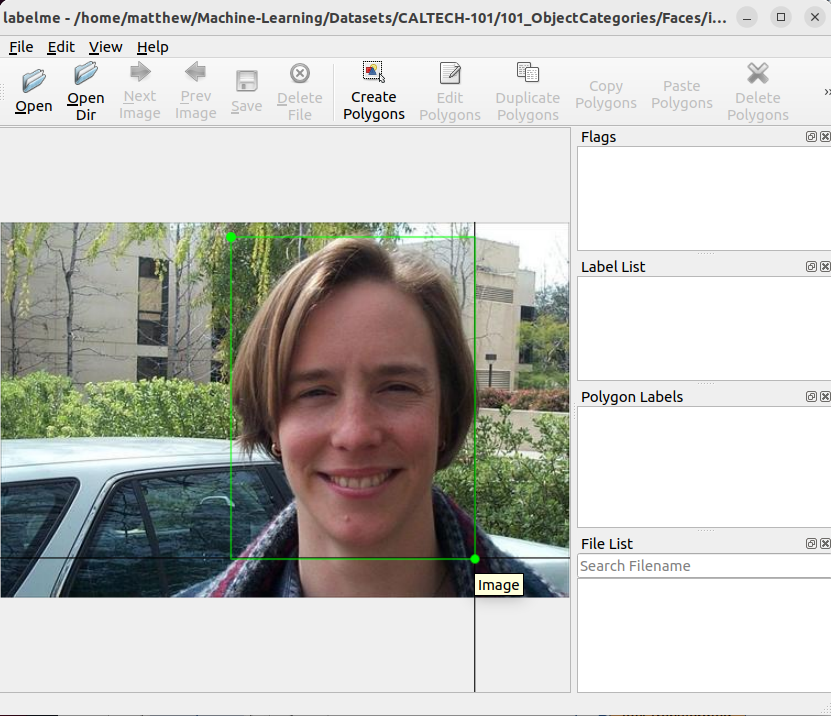

***
## Scaling Annotations

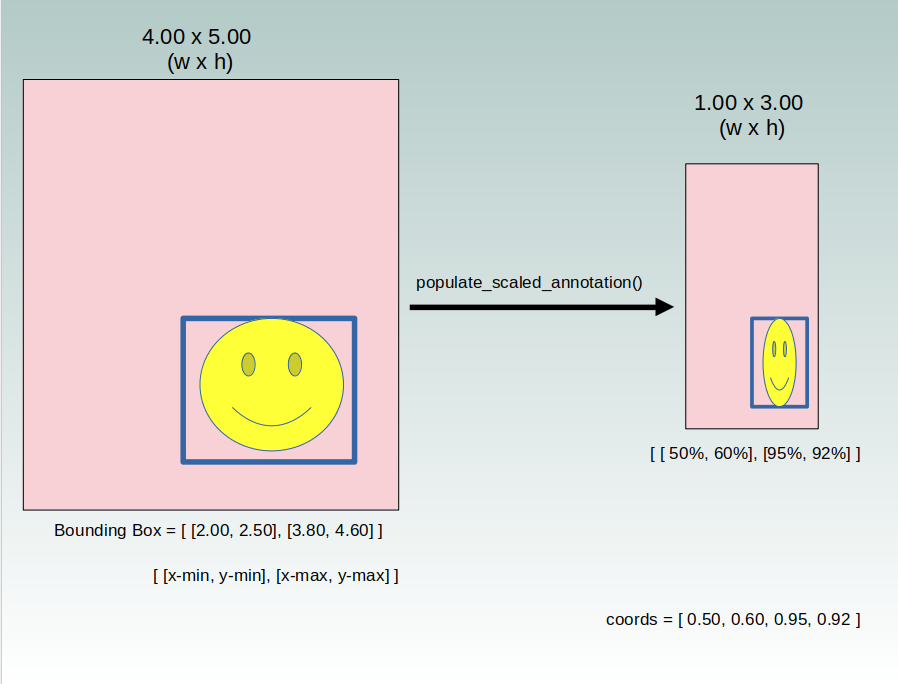

In [6]:
def populate_scaled_annotations(images_path = "./dataset/images", 
                           annotations_path = "./dataset/annotations"):
    
    for file in os.listdir(os.path.join(images_path)):
        # Skip the .ipynb_checkpoints directory 
        if file.startswith('.ipynb_checkpoints'):
            continue
        
        image = cv2.imread(os.path.join(images_path, file))
        annot_path = os.path.join(annotations_path, f'{file.split(".")[0]}.json')
        (image_height, image_width) = image.shape[:2]
        
        # Dictionary; these values will change if there is an annotation
        # *** I've learned the hard way that "coords" has to be a list of lists ***
        # Images with no faces will just have an empty list
        data = {
            'original_image': file,
            'coords': [],
            'class': 0
        }
        
        if os.path.exists(annot_path):
            
            with open(annot_path, "r") as f:
                annotation_data = json.load(f)
                
                        # Check if the annotation has bounding box information
            if "shapes" in annotation_data:
                for set_of_coordinates in annotation_data["shapes"]:
                    # Iterate through all sets of bounding box coordinates in nested_points
                    nested_points = set_of_coordinates.get("points", [])
                    
                    # Convert original coordinates to percentages
                    x_min, y_min = nested_points[0]
                    x_max, y_max = nested_points[1]
                    
                    # Scale coordinates to percentages
                    x_min /= image_width
                    y_min /= image_height
                    x_max /= image_width
                    y_max /= image_height
                    
                    # Add the scaled coordinates to the 'coords' list
                    data['coords'].append([x_min, y_min, x_max, y_max])
                    
                data['class'] = 1
            
        
        # Write to file
        json_file_path = "./pipeline-data/scaled-annotations/" + f'{file.split(".")[0]}.json'
        with open(json_file_path, "w") as json_file:
            json.dump(data, json_file, indent = 4)

In [7]:
populate_scaled_annotations()

***
#### Number of original sample images

In [8]:
!ls -l ./dataset/images/ | grep "^-" | wc -l

701


#### Number of original faces

In [9]:
!ls -l ./dataset/images/ | grep "^-" | grep "^.*image" | wc -l

435


#### Average dimensions of face images
("identify" command is from the imagemagick library)

In [10]:
!identify -format "%w %h\n" ./dataset/images/image* | awk '{ sum_width += $1; sum_height += $2 } END { printf "Average width: %.2f\nAverage height: %.2f\n", sum_width/NR, sum_height/NR }'

Average width: 504.25
Average height: 332.99


***

## Scaling
- Scale image dimensions to 500 x 300

In [11]:
def scale_images(input_folder = "./dataset/images", 
                     output_folder = "./pipeline-data/scaled-images", 
                     width = 500, 
                     height = 300):
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Get the list of image files
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for file in image_files:
        # Read the image
        input_path = os.path.join(input_folder, file)
        image = cv2.imread(input_path)

        # Resize the image
        resized_image = cv2.resize(image, (width, height))

        # Write the resized image to the output directory
        output_path = os.path.join(output_folder, file)
        cv2.imwrite(output_path, resized_image)

In [12]:
scale_images()

***
## Train, Test, Validation
(I would like to use sk-learn's train_test_split, but there's something weird going on with Tensorflow and numpy versioning)

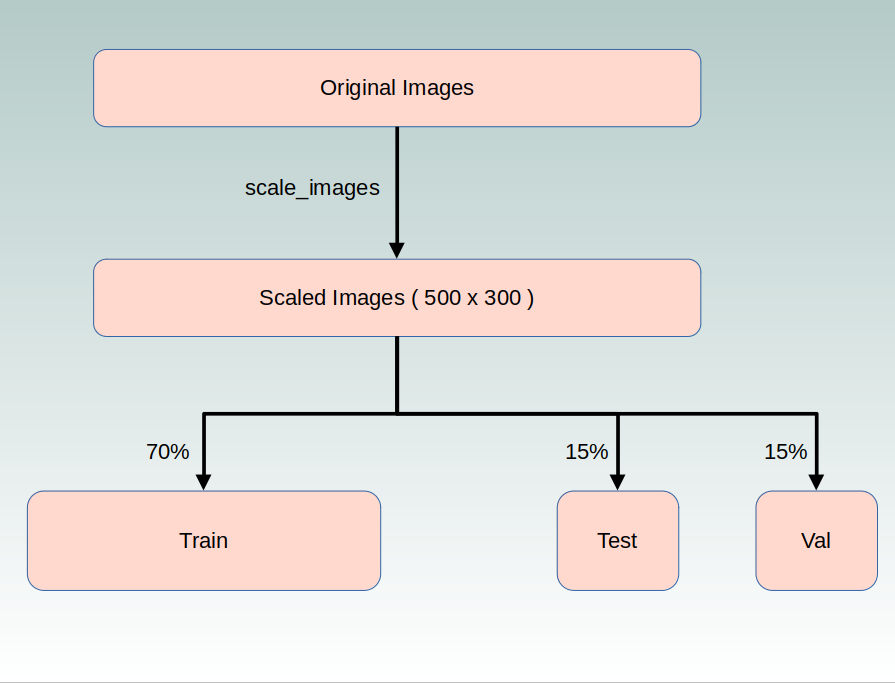

In [13]:
def my_train_test_split(input_images_folder = "./pipeline-data/scaled-images/",
                        input_annotations_folder = "./pipeline-data/scaled-annotations",
                        output_train_images = "./pipeline-data/train/images", 
                        output_test_images = "./pipeline-data/test/images", 
                        output_val_images = "./pipeline-data/val/images",
                        output_train_annotations = "./pipeline-data/train/annotations",
                        output_test_annotations = "./pipeline-data/test/annotations",
                        output_val_annotations = "./pipeline-data/val/annotations",
                        train_size = 0.70, 
                        test_size = 0.15, 
                        val_size = 0.15, 
                        random_seed = 93):
    
    random.seed(random_seed)
    
    # Get the list of image files
    image_files = [f for f in os.listdir(input_images_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Shuffle the list of files
    random.shuffle(image_files)
    
    # Calculate the number of files for each set
    num_files = len(image_files)
    num_train_files = int(num_files * train_size)
    num_test_files = int(num_files * test_size)
    num_val_files = num_files - num_train_files - num_test_files
    
    # Create output directories if they don't exist
    os.makedirs(output_train_images, exist_ok=True)
    os.makedirs(output_test_images, exist_ok=True)
    os.makedirs(output_val_images, exist_ok=True)
    os.makedirs(output_train_annotations, exist_ok=True)
    os.makedirs(output_test_annotations, exist_ok=True)
    os.makedirs(output_val_annotations, exist_ok=True)
    
     # Copy files to train set
    for file in image_files[:num_train_files]:
        # Copy images
        input_image_path = os.path.join(input_images_folder, file)
        output_image_path = os.path.join(output_train_images, file)
        shutil.copy(input_image_path, output_image_path)

        # Copy corresponding annotations
        input_annotation_path = os.path.join(input_annotations_folder, file.replace('.jpg', '.json'))
        output_annotation_path = os.path.join(output_train_annotations, file.replace('.jpg', '.json'))
        shutil.copy(input_annotation_path, output_annotation_path)
    
    # Copy files to test set
    for file in image_files[num_train_files:num_train_files + num_test_files]:
        # Copy images
        input_image_path = os.path.join(input_images_folder, file)
        output_image_path = os.path.join(output_test_images, file)
        shutil.copy(input_image_path, output_image_path)

        # Copy corresponding annotations
        input_annotation_path = os.path.join(input_annotations_folder, file.replace('.jpg', '.json'))
        output_annotation_path = os.path.join(output_test_annotations, file.replace('.jpg', '.json'))
        shutil.copy(input_annotation_path, output_annotation_path)

    # Copy files to validation set
    for file in image_files[num_train_files + num_test_files:]:
        # Copy images
        input_image_path = os.path.join(input_images_folder, file)
        output_image_path = os.path.join(output_val_images, file)
        shutil.copy(input_image_path, output_image_path)

        # Copy corresponding annotations
        input_annotation_path = os.path.join(input_annotations_folder, file.replace('.jpg', '.json'))
        output_annotation_path = os.path.join(output_val_annotations, file.replace('.jpg', '.json'))
        shutil.copy(input_annotation_path, output_annotation_path)

In [14]:
# I will probably want to re-do the split at some point.

def reset_split(paths = ["./pipeline-data/train/images", 
                         "./pipeline-data/test/images", 
                         "./pipeline-data/val/images", 
                         "./pipeline-data/train/annotations", 
                         "./pipeline-data/test/annotations", 
                         "./pipeline-data/val/annotations",
                        "./pipeline-data/train-transformed/images", 
                         "./pipeline-data/test-transformed/images", 
                         "./pipeline-data/val-transformed/images",
                        "./pipeline-data/train-transformed/annotations", 
                         "./pipeline-data/test-transformed/annotations", 
                         "./pipeline-data/val-transformed/annotations"]):
    
    for directory_path in paths:
        # Check if the directory exists
        if os.path.exists(directory_path):
            # Remove all files and subdirectories within the directory
            for file_name in os.listdir(directory_path):
                file_path = os.path.join(directory_path, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            print(f"Cleared contents of {directory_path}")
        else:
            print(f"Directory {directory_path} does not exist.")

In [15]:
# Already needed it...
reset_split()

Cleared contents of ./pipeline-data/train/images
Cleared contents of ./pipeline-data/test/images
Cleared contents of ./pipeline-data/val/images
Cleared contents of ./pipeline-data/train/annotations
Cleared contents of ./pipeline-data/test/annotations
Cleared contents of ./pipeline-data/val/annotations
Cleared contents of ./pipeline-data/train-transformed/images
Cleared contents of ./pipeline-data/test-transformed/images
Cleared contents of ./pipeline-data/val-transformed/images
Cleared contents of ./pipeline-data/train-transformed/annotations
Cleared contents of ./pipeline-data/test-transformed/annotations
Cleared contents of ./pipeline-data/val-transformed/annotations


In [16]:
my_train_test_split()

***
## Loading images
I need to implement a way to actually look at these images along with the bounding boxes before I try to
augment the training data. Otherwise, I feel like I won't have anything to compare.

#### Example annotation and original image:

{'class': 1,
 'coords': [[0.40659970041413335,
             0.10326969672764065,
             0.7678650101330513,
             0.8754293473919642]],
 'original_image': 'image_0298.jpg'}


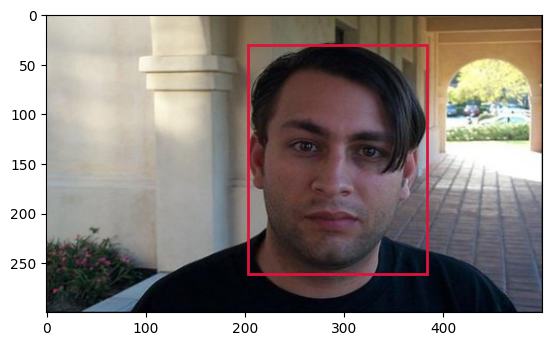

In [17]:
example_image_dir = "./pipeline-data/train/images"
all_images_in_dir = os.listdir(example_image_dir)
all_faces = fnmatch.filter(all_images_in_dir, "image*")

# Just get the first match, first_face
first_face_image = os.path.join(example_image_dir, all_faces[0])
filename_only = os.path.basename(first_face_image)

first_face_ann = os.path.join("./pipeline-data/train/annotations", filename_only.replace("jpg", "json"))

with open(first_face_ann, "r") as json_file:
    json_content = json.load(json_file)
    
print("=======================================")
pprint(json_content)
print("=======================================")


fg, ax = plt.subplots()

# ============ Standard image printing ===================

example_image = cv2.imread(first_face_image)
ax.imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))

# --------------------------------------------------------


# ========== Drawing bounding boxes =====================
# This would actually draw multiple bounding boxes
# Getting this working was very painful...

# Drawing bounding boxes
for bbox in json_content["coords"]:
    # Use the coordinates directly without unpacking
    x_min, y_min, x_max, y_max = bbox

    width = x_max - x_min
    height = y_max - y_min

    # Convert percentages to pixel coordinates
    x_min_pixel = int(x_min * example_image.shape[1])
    y_min_pixel = int(y_min * example_image.shape[0])
    width_pixel = int(width * example_image.shape[1])
    height_pixel = int(height * example_image.shape[0])

    # Create a Rectangle patch
    rect = patches.Rectangle((x_min_pixel, y_min_pixel),
                             width_pixel,
                             height_pixel,
                             linewidth = 2,
                             edgecolor = "crimson",
                             facecolor = "none")
    ax.add_patch(rect)

plt.show()

It takes quite a bit of code to get a face and its annotation. So, I'll go ahead and make a function for that - I'll also make it draw a bounding box with the coords.

In [18]:
def display_image_with_ann(partition, image_name):
    if not image_name.endswith(".jpg"):
        image_name += ".jpg"
    
    image_path = os.path.join("./pipeline-data", partition, "images", image_name)
    ann_path = os.path.join("./pipeline-data", partition, "annotations", image_name.replace("jpg", "json"))
    
    with open(ann_path, "r") as json_file:
        json_content = json.load(json_file)
    
    print("=======================================")
    pprint(json_content)
    print("=======================================")
    
    fg, ax = plt.subplots()
    
    # ============ Standard image printing ===================
    image = cv2.imread(image_path)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # ========== Drawing bounding boxes =====================
    for bbox in json_content["coords"]:
        # Use the coordinates directly without unpacking
        x_min, y_min, x_max, y_max = bbox

        width = x_max - x_min
        height = y_max - y_min

        # Still use percentages to pixel coordinate
        x_min_pixel = int(x_min * example_image.shape[1])
        y_min_pixel = int(y_min * example_image.shape[0])
        width_pixel = int(width * example_image.shape[1])
        height_pixel = int(height * example_image.shape[0])

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min_pixel, y_min_pixel),
                                 width_pixel,
                                 height_pixel,
                                 linewidth = 2,
                                 edgecolor = "crimson",
                                 facecolor = "none")
    ax.add_patch(rect)

    plt.show()
        

{'class': 1,
 'coords': [[0.31384893665595426,
             0.15717930319700238,
             0.7054686265212581,
             0.8933136676499509]],
 'original_image': 'image_0339.jpg'}


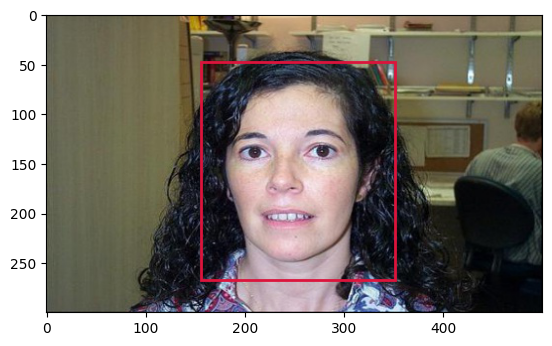

In [19]:
# Let's see if it works...
display_image_with_ann("val", "image_0339")

The cell below is a screenshot of output after running the ANN. It looks like I need more samples to do a significant number of epochs.
<br>
<br>
At least I know it will be possible to get a final working model now!
<br>
<br>
The new hurdle is that I need to expand the training set by augmenting the training images. There are two options for this:
1. Save transformed images and annotations to the train-tansformed folder.
2. Do the transformation right after an image is loaded and immediately feed the ANN the augmented image and data.

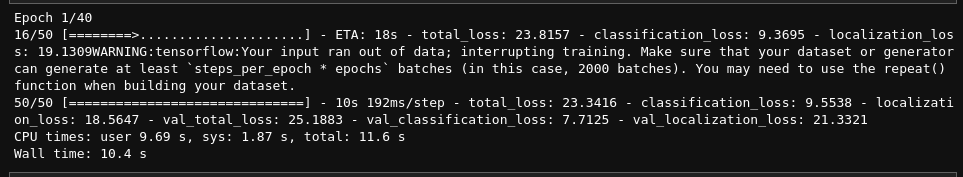

***
## Augmentation Setup

In [20]:
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width = 300,height = 300),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.VerticalFlip(p = 0.5)], 
                        bbox_params = alb.BboxParams(format="albumentations", label_fields = ["class_labels"]))

In [21]:
img = cv2.imread(os.path.join("pipeline-data", "train", "images", "image_0060.jpg"))

with open(os.path.join("pipeline-data", "train", "annotations", "image_0060.json"), "r") as json_file:
    label = json.load(json_file)

In [22]:
augmented = augmentor(image = img, 
                      bboxes = label["coords"], 
                      class_labels = ["class"])

In [23]:
with open(os.path.join("pipeline-data", "train", "annotations", "image_0060.json"), "r") as f:
    label = json.load(f)
    
pprint(label)

{'class': 1,
 'coords': [[0.3342151675485009,
             0.0997438360550753,
             0.68342151675485,
             0.9216031593553208]],
 'original_image': 'image_0060.jpg'}


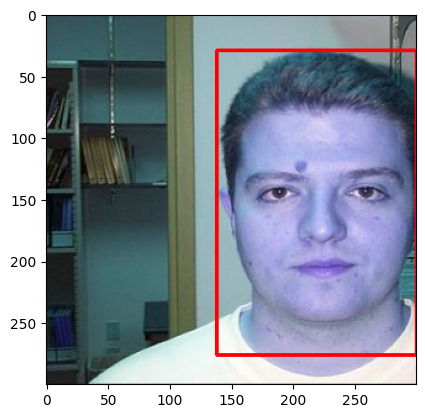

In [24]:
cv2.rectangle(augmented["image"], 
              tuple(np.multiply(augmented["bboxes"][0][:2], [300,300]).astype(int)),
              tuple(np.multiply(augmented["bboxes"][0][2:], [300,300]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented["image"])

***
## Applying augmentations to all partitions

In [25]:
def transform_folder(partition, transformations_per_image):
    
    augmentor = alb.Compose([
        alb.RandomCrop(width=256, height=256),
        alb.HorizontalFlip(p=0.5),
        alb.RandomBrightnessContrast(p=0.2),
        alb.RandomGamma(p=0.2),
        alb.RGBShift(p=0.2),
        alb.VerticalFlip(p=0.5)
    ], bbox_params=alb.BboxParams(format="albumentations", label_fields=['class_labels']))

    for image_file in os.listdir(os.path.join("pipeline-data", partition, "images")):
        
        # Skip these, ugh...
        if ".ipynb_checkpoints" in image_file:
            continue
        
        image_path = os.path.join("pipeline-data", partition, "images", image_file)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        with open(os.path.join("pipeline-data", 
                               partition, 
                               "annotations", 
                               f"{image_file.split('.')[0]}.json"), "r") as f:
            
            label = json.load(f)

        coords = label.get("coords", [])
        

        try:
            for x in range(transformations_per_image):
                data = {
                    'image': f"{image_file.split('.')[0]}_{x}.jpg",
                    'class': label["class"]
                }
                
                if not coords:
                    # I really had to pass in dummy values for the bboxes...
                    augmented = augmentor(image = image, 
                                          bboxes = np.array([[0, 0, 0.1, 0.1]]), 
                                          class_labels = ["class"])
                    
                    data["coords"] = [0, 0, 0, 0]
                    
                    output_image_path = os.path.join("pipeline-data", 
                                                     f"{partition}-transformed", 
                                                     "images", 
                                                     f"{image_file.split('.')[0]}_{x}.jpg")
                    
                    cv2.imwrite(output_image_path, augmented["image"])
                    
                else:
                    augmented = augmentor(image=image, 
                                          bboxes = np.array(coords), 
                                          class_labels=["class"])

                    output_image_path = os.path.join("pipeline-data", 
                                                     f"{partition}-transformed", 
                                                     "images", 
                                                     f"{image_file.split('.')[0]}_{x}.jpg")
                    
                    cv2.imwrite(output_image_path, augmented["image"])
                    
                    
                    # Ensure the augmented bounding box is not empty
                    if augmented["bboxes"]:
                        data["coords"] = augmented["bboxes"][0]
                        
                        
                        
                json_output_path = os.path.join("pipeline-data", 
                                                f"{partition}-transformed", 
                                                "annotations", 
                                                f"{image_file.split('.')[0]}_{x}.json")
                
                
                
                with open(json_output_path, "w") as json_file:
                    json.dump(data, json_file, indent=4)

                    
        except Exception as e:
            print(e)

In [26]:
%%time
transform_folder("train", 10)

CPU times: user 14 s, sys: 416 ms, total: 14.4 s
Wall time: 14.4 s


In [27]:
%%time
transform_folder("test", 10)

CPU times: user 2.97 s, sys: 104 ms, total: 3.08 s
Wall time: 3.08 s


In [28]:
%%time
transform_folder("val", 10)

CPU times: user 3 s, sys: 95.8 ms, total: 3.1 s
Wall time: 3.1 s


### Recheck annotations
Albumentations will delete the bounding box coordinates if they are shifted out of frame. This is very convenient! But that means some pictures that were labelled as "face" no longer actually contain a face. The pictures themselves don't need to be changed, but the annotations must be updated to match those of the "no face" class.

In [29]:
def add_coords_to_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)

            with open(file_path, 'r') as file:
                label = json.load(file)

            # Check if "coords" key is missing
            if "coords" not in label:
                print("coords not found in: ", directory, "adding coords = [0, 0, 0, 0]")
                # Add "coords" key with the specified format [0, 0, 0, 0]
                label["coords"] = [0, 0, 0, 0]
                label["class"] = 0

                # Save the modified JSON back to the file
                with open(file_path, 'w') as file:
                    json.dump(label, file, indent = 4)

In [30]:
add_coords_to_files("./pipeline-data/train-transformed/annotations")
add_coords_to_files("./pipeline-data/test-transformed/annotations")
add_coords_to_files("./pipeline-data/val-transformed/annotations")

In [31]:
def load_annotations(annot_path):
    with open(annot_path.numpy(), "r", encoding = "utf-8") as f:
        label = json.load(f)
        
        # Grab only first label["coords"]
    return [label["class"]], label["coords"]

In [32]:
train_labels = tf.data.Dataset.list_files("./pipeline-data/train-transformed/annotations/*json", 
                                          shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))

2023-12-07 00:32:38.515771: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 00:32:38.519545: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-07 00:32:38.705665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-12-07 00:32:38.705871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock

In [33]:
test_labels = tf.data.Dataset.list_files("./pipeline-data/test-transformed/annotations/*json", 
                                          shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))

In [34]:
val_labels = tf.data.Dataset.list_files("./pipeline-data/val-transformed/annotations/*json", 
                                          shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))

In [35]:
train_labels.as_numpy_iterator().next()

2023-12-07 00:32:41.053839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-07 00:32:41.055784: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

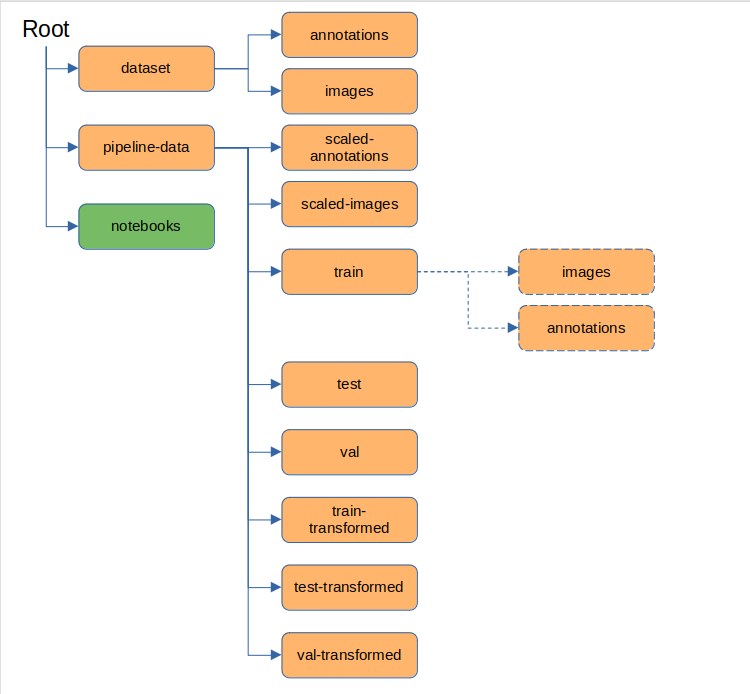

#### Images to tensors

In [36]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [37]:
train_images = tf.data.Dataset.list_files("./pipeline-data/train-transformed/images/*jpg", shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (256, 256)))
train_images = train_images.map(lambda x : x/255)

In [38]:
test_images = tf.data.Dataset.list_files("./pipeline-data/test-transformed/images/*jpg", shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (256, 256)))
test_images = test_images.map(lambda x : x/255)

In [39]:
val_images = tf.data.Dataset.list_files("./pipeline-data/val-transformed/images/*jpg", shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (256, 256)))
val_images = val_images.map(lambda x : x/255)

In [40]:
train_images.as_numpy_iterator().next()

array([[[0.7529412 , 0.7490196 , 0.627451  ],
        [0.77254903, 0.76862746, 0.64705884],
        [0.7921569 , 0.78039217, 0.65882355],
        ...,
        [0.44313726, 0.44313726, 0.4117647 ],
        [0.43529412, 0.43529412, 0.39607844],
        [0.42745098, 0.42745098, 0.3882353 ]],

       [[0.6392157 , 0.6431373 , 0.5176471 ],
        [0.654902  , 0.6509804 , 0.5294118 ],
        [0.6666667 , 0.654902  , 0.53333336],
        ...,
        [0.44705883, 0.44705883, 0.41568628],
        [0.4509804 , 0.4509804 , 0.4117647 ],
        [0.44705883, 0.44705883, 0.40784314]],

       [[0.6431373 , 0.65882355, 0.5294118 ],
        [0.6627451 , 0.6666667 , 0.5411765 ],
        [0.6784314 , 0.6627451 , 0.54901963],
        ...,
        [0.4509804 , 0.4509804 , 0.41960785],
        [0.4627451 , 0.4627451 , 0.43137255],
        [0.4509804 , 0.4509804 , 0.41960785]],

       ...,

       [[0.8627451 , 0.76862746, 0.627451  ],
        [0.99215686, 0.91764706, 0.8       ],
        [1.        , 0

#### Zip labels and images

In [41]:
print("Train:", len(train_images), len(train_labels))
print("Test:", len(test_images), len(test_labels))
print("Val:", len(val_images), len(val_labels))

Train: 4900 4900
Test: 1050 1050
Val: 1060 1060


In [42]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(32)
train = train.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(32)
test = test.prefetch(4)

In [44]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(32)
val = val.prefetch(4)

#### Double checking that there are no missing coordinates in the annotations

In [45]:
def find_files_missing_coords(directory):
    missing_coords_files = []

    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)

            with open(file_path, 'r') as file:
                label = json.load(file)

            if "coords" not in label:
                missing_coords_files.append(filename)

    if missing_coords_files:
        print("Files missing 'coords' key:")
        for missing_file in missing_coords_files:
            print(f"- {missing_file}")
    else:
        print("All files have the 'coords' key.")

# Example usage
directory_path = "./pipeline-data/train-transformed/annotations"
find_files_missing_coords(directory_path)


All files have the 'coords' key.


In [46]:
train.as_numpy_iterator().next()[1]

2023-12-07 00:32:51.452722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3252 of 5000
2023-12-07 00:32:58.227950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.      , 0.      , 0.4678  , 0.906   ],
        [0.      , 0.0874  , 0.4727  , 1.      ],
        [0.129   , 0.0688  , 0.987   , 1.      ],
        [0.125   , 0.11914 , 0.9033  , 1.      ],
        [0.      , 0.10004 , 0.7036  , 0.9937  ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.2018  , 0.0942  , 1.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.2081  , 0.02612 , 0.926   , 0.853   ],
        [0.3328  , 0.      , 1.      , 0.9316  ],
        [0.      , 0.      , 0.5103  , 0.757   ],
        [0.0902  , 

***
***
***
***
## Building a Model

VGG16 info: https://conx.readthedocs.io/en/latest/VGG16%20and%20ImageNet.html

In [47]:
VGG16(include_top = False).summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

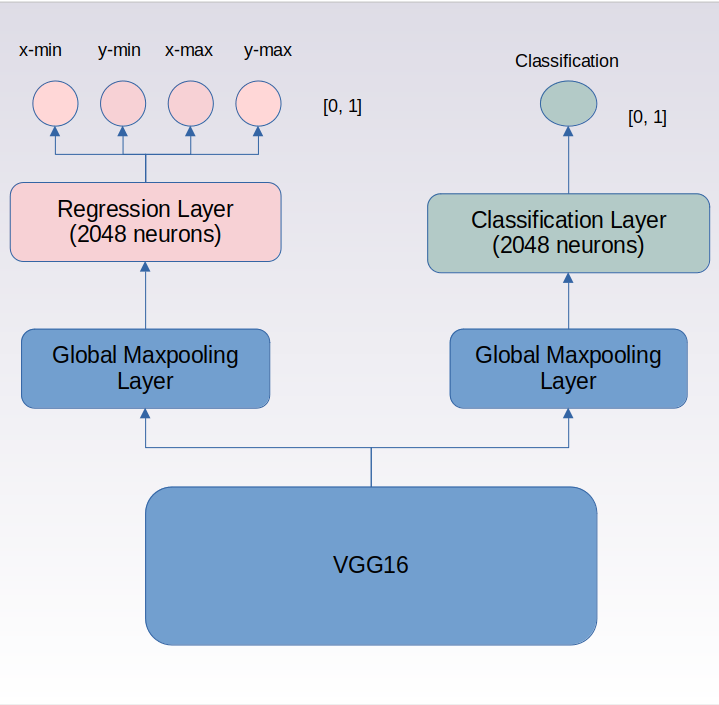

### "Global Maxpooling?"

I think this article by Oreolorun Olu-Ipinlaye (https://blog.paperspace.com/global-pooling-in-convolutional-neural-networks/) goes into depth on what these layers are for. He uses PyTorch, but the concept is still the same. If my understanding is correct, the GlobalMaxPooling layers are used to fit the headless VGG16 model to the new heads. It only feeds the next layers the most important ("most activated") neurons.

In [48]:
def build_model():
    
    input_layer = Input(shape = (256, 256, 3))
    # Using VGG16 here
    vgg16 = VGG16(include_top = False)(input_layer)
    
    
    # ============= Classification =======================================================
    condensing_layer_1 = GlobalMaxPooling2D()(vgg16)
    classification_layer_1 = Dense(2048, activation = "relu")(condensing_layer_1)
    classification_output_layer = Dense(1, activation = "sigmoid")(classification_layer_1)
    
    
    # ============= Bounding Box Regression ==============================================
    condensing_layer_2 = GlobalMaxPooling2D()(vgg16)
    regression_layer_1 = Dense(2048, activation = "relu")(condensing_layer_2)
    regression_output_layer = Dense(4, activation = "sigmoid")(regression_layer_1)
    
    
    
    myModel = Model(inputs = input_layer, outputs = [classification_output_layer, regression_output_layer])
    myModel.build(input_shape = (None, 256, 256, 3))
    return myModel

In [49]:
myModel = build_model()
myModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

In [50]:
X, y = train.as_numpy_iterator().next()

2023-12-07 00:33:08.938713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3057 of 5000
2023-12-07 00:33:15.367014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


### Taking a look at what's fed into the Neural Network

In [51]:
X.shape

(32, 256, 256, 3)

In [52]:
classes, coords = myModel.predict(X)

2023-12-07 00:33:15.555057: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-12-07 00:33:16.087943: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-12-07 00:33:18.254811: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-12-07 00:33:18.454261: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


***
## Loss Functions

In [53]:
len(train)

154

In [54]:
batches_per_epoch = len(train)
learning_rate_decay = (1. / 0.75 - 1)/batches_per_epoch

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = learning_rate_decay)

In [56]:
def localization_loss(y_true, y_predicted):
    
    delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - y_predicted[:,:2]))
    # print("delta_coords = ", delta_coords)
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    # print("h_true = ", h_true)
    # print("w_true = ", w_true)
    
    h_predicted = y_predicted[:,3] - y_predicted[:,1]
    w_predicted = y_predicted[:,2] - y_predicted[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_predicted) + tf.square(h_true - h_predicted))
    
    return delta_coords + delta_size

In [57]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
localization_loss = localization_loss

Passing through the test instance to make sure this actually works... This has been difficult so far...

In [58]:
localization_loss(y[1], coords).numpy()

56.439087

***
## Custom Model

In [59]:
class FaceLocalizer(Model):
    def __init__(self, myModel, **kwargs):
        super().__init__(**kwargs)
        self.model = myModel
        
    def compile(self, optimizer, classification_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.localization_loss = localization_loss
        self.optimizer = optimizer
    
    # One batch at a time, of course
    def train_step(self, batch, **kwargs):
        # X = image
        # y = labels
        # y[0] = classes, y[1] = bounding box coordinates
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction from the model by passing through an image
            classes, coords = self.model(X, training = True)
            
            # Calculate losses
            batch_classification_loss = self.classification_loss(y[0], classes)
            batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
            
            # Could change how this is calculated
            total_loss = batch_localization_loss + 0.5 * batch_classification_loss
            
            gradient = tape.gradient(total_loss, self.model.trainable_variables)
            
        # This is actually the back propagation
        optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training = False)
        
        batch_classification_loss = self.classification_loss(y[0], classes)
        batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localization_loss + 0.5 * batch_classification_loss
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
        
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [60]:
model = FaceLocalizer(myModel)

In [61]:
model.compile(optimizer, 
              classification_loss = classification_loss, 
              localization_loss = localization_loss)

In [62]:
%%time
history = model.fit(train, 
                    validation_data = val, 
                    epochs = 24)

Epoch 1/24


2023-12-07 00:33:53.177894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3618 of 5000
2023-12-07 00:33:56.020731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 152s 648ms/step - total_loss: 2.0338 - classification_loss: 0.0901 - localization_loss: 1.9887 - val_total_loss: 0.0601 - val_classification_loss: 0.0017 - val_localization_loss: 0.0592
Epoch 2/24


2023-12-07 00:36:24.207428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2436 of 5000
2023-12-07 00:36:33.338122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 249ms/step - total_loss: 0.5412 - classification_loss: 0.0136 - localization_loss: 0.5344 - val_total_loss: 0.0154 - val_classification_loss: 4.5794e-04 - val_localization_loss: 0.0152
Epoch 3/24


2023-12-07 00:37:21.707185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3337 of 5000
2023-12-07 00:37:27.238834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 247ms/step - total_loss: 0.3189 - classification_loss: 0.0037 - localization_loss: 0.3170 - val_total_loss: 0.3509 - val_classification_loss: 0.1381 - val_localization_loss: 0.2819
Epoch 4/24


2023-12-07 00:38:15.298061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3176 of 5000
2023-12-07 00:38:20.390914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 249ms/step - total_loss: 0.2080 - classification_loss: 0.0019 - localization_loss: 0.2071 - val_total_loss: 0.0203 - val_classification_loss: 0.0026 - val_localization_loss: 0.0189
Epoch 5/24


2023-12-07 00:39:08.845593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2971 of 5000
2023-12-07 00:39:15.382470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 236ms/step - total_loss: 0.1361 - classification_loss: 1.5759e-04 - localization_loss: 0.1360 - val_total_loss: 0.0133 - val_classification_loss: 3.6171e-04 - val_localization_loss: 0.0131
Epoch 6/24


2023-12-07 00:40:01.782408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2609 of 5000
2023-12-07 00:40:10.881231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 246ms/step - total_loss: 0.1091 - classification_loss: 9.8832e-05 - localization_loss: 0.1090 - val_total_loss: 0.0307 - val_classification_loss: 1.1874e-04 - val_localization_loss: 0.0306
Epoch 7/24


2023-12-07 00:40:58.731870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2505 of 5000
2023-12-07 00:41:06.692755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 239ms/step - total_loss: 0.0896 - classification_loss: 7.4534e-05 - localization_loss: 0.0895 - val_total_loss: 0.0056 - val_classification_loss: 8.3691e-05 - val_localization_loss: 0.0056
Epoch 8/24


2023-12-07 00:41:53.507425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2993 of 5000
2023-12-07 00:42:00.775016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 241ms/step - total_loss: 0.0743 - classification_loss: 5.2240e-05 - localization_loss: 0.0743 - val_total_loss: 0.0110 - val_classification_loss: 1.9698e-04 - val_localization_loss: 0.0109
Epoch 9/24


2023-12-07 00:42:48.018110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2885 of 5000
2023-12-07 00:42:54.056952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 250ms/step - total_loss: 0.0569 - classification_loss: 3.9779e-05 - localization_loss: 0.0569 - val_total_loss: 0.0053 - val_classification_loss: 4.4826e-05 - val_localization_loss: 0.0053
Epoch 10/24


2023-12-07 00:43:42.639154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2670 of 5000
2023-12-07 00:43:50.858912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 250ms/step - total_loss: 0.0462 - classification_loss: 2.5383e-05 - localization_loss: 0.0462 - val_total_loss: 2.5105 - val_classification_loss: 1.7188 - val_localization_loss: 1.6511
Epoch 11/24


2023-12-07 00:44:39.468741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3350 of 5000
2023-12-07 00:44:43.789808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 244ms/step - total_loss: 0.0430 - classification_loss: 2.1662e-05 - localization_loss: 0.0430 - val_total_loss: 0.0071 - val_classification_loss: 5.0235e-05 - val_localization_loss: 0.0071
Epoch 12/24


2023-12-07 00:45:31.394116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3019 of 5000
2023-12-07 00:45:36.564990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 258ms/step - total_loss: 0.0361 - classification_loss: 1.7031e-05 - localization_loss: 0.0361 - val_total_loss: 0.1243 - val_classification_loss: 0.0055 - val_localization_loss: 0.1215
Epoch 13/24


2023-12-07 00:46:26.412879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3334 of 5000
2023-12-07 00:46:31.574757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 254ms/step - total_loss: 0.0321 - classification_loss: 1.4632e-05 - localization_loss: 0.0321 - val_total_loss: 6.7588e-05 - val_classification_loss: 2.1786e-05 - val_localization_loss: 5.6695e-05
Epoch 14/24


2023-12-07 00:47:20.724305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3102 of 5000
2023-12-07 00:47:25.710703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 255ms/step - total_loss: 0.0273 - classification_loss: 1.0859e-05 - localization_loss: 0.0273 - val_total_loss: 0.0052 - val_classification_loss: 2.0504e-05 - val_localization_loss: 0.0052
Epoch 15/24


2023-12-07 00:48:14.960477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3566 of 5000
2023-12-07 00:48:19.744073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 244ms/step - total_loss: 0.0253 - classification_loss: 9.3784e-06 - localization_loss: 0.0253 - val_total_loss: 0.0054 - val_classification_loss: 5.9456e-06 - val_localization_loss: 0.0054
Epoch 16/24


2023-12-07 00:49:07.303031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2967 of 5000
2023-12-07 00:49:13.727480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 259ms/step - total_loss: 0.0217 - classification_loss: 8.9971e-06 - localization_loss: 0.0217 - val_total_loss: 0.0036 - val_classification_loss: 4.8983e-05 - val_localization_loss: 0.0036
Epoch 17/24


2023-12-07 00:50:03.653506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4523 of 5000
2023-12-07 00:50:04.472954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 49s 251ms/step - total_loss: 0.0205 - classification_loss: 7.8396e-06 - localization_loss: 0.0205 - val_total_loss: 0.0383 - val_classification_loss: 2.4587e-06 - val_localization_loss: 0.0383
Epoch 18/24


2023-12-07 00:50:53.129888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3543 of 5000
2023-12-07 00:50:56.343681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 252ms/step - total_loss: 0.0186 - classification_loss: 6.8917e-06 - localization_loss: 0.0186 - val_total_loss: 0.0197 - val_classification_loss: 1.5080e-05 - val_localization_loss: 0.0197
Epoch 19/24


2023-12-07 00:51:45.125704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3102 of 5000
2023-12-07 00:51:49.171911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 273ms/step - total_loss: 0.0162 - classification_loss: 6.0493e-06 - localization_loss: 0.0162 - val_total_loss: 0.0162 - val_classification_loss: 8.0466e-07 - val_localization_loss: 0.0162
Epoch 20/24


2023-12-07 00:52:41.151237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4371 of 5000
2023-12-07 00:52:42.964046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 257ms/step - total_loss: 0.0158 - classification_loss: 5.7290e-06 - localization_loss: 0.0158 - val_total_loss: 0.0227 - val_classification_loss: 1.5944e-06 - val_localization_loss: 0.0227
Epoch 21/24


2023-12-07 00:53:32.471934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3151 of 5000
2023-12-07 00:53:39.139667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 257ms/step - total_loss: 0.0141 - classification_loss: 4.6317e-06 - localization_loss: 0.0141 - val_total_loss: 0.0102 - val_classification_loss: 1.5348e-06 - val_localization_loss: 0.0102
Epoch 22/24


2023-12-07 00:54:28.812942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3791 of 5000
2023-12-07 00:54:31.628019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 261ms/step - total_loss: 0.0137 - classification_loss: 4.3722e-06 - localization_loss: 0.0137 - val_total_loss: 0.0633 - val_classification_loss: 1.5348e-06 - val_localization_loss: 0.0633
Epoch 23/24


2023-12-07 00:55:21.868938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3298 of 5000
2023-12-07 00:55:26.713773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 263ms/step - total_loss: 0.0129 - classification_loss: 4.3849e-06 - localization_loss: 0.0129 - val_total_loss: 0.0117 - val_classification_loss: 1.9372e-07 - val_localization_loss: 0.0117
Epoch 24/24


2023-12-07 00:56:17.277187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3451 of 5000
2023-12-07 00:56:22.442554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 257ms/step - total_loss: 0.0127 - classification_loss: 4.1426e-06 - localization_loss: 0.0127 - val_total_loss: 0.0070 - val_classification_loss: 3.8743e-07 - val_localization_loss: 0.0070
CPU times: user 18min 54s, sys: 2min 8s, total: 21min 3s
Wall time: 23min 19s


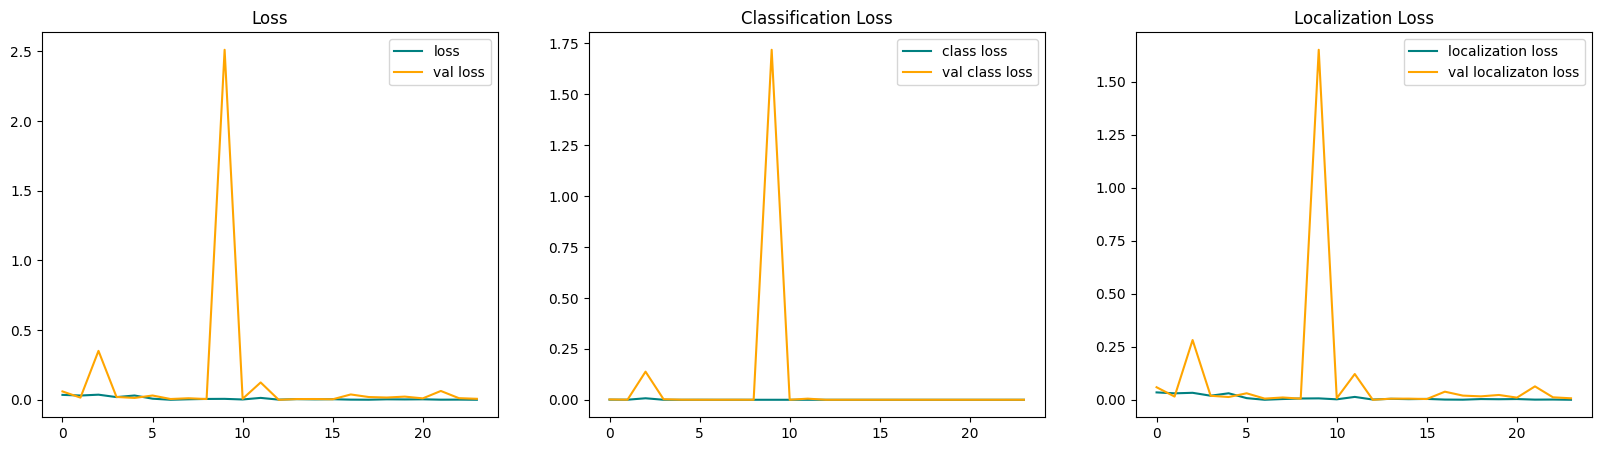

In [63]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['localization_loss'], color='teal', label='localization loss')
ax[2].plot(history.history['val_localization_loss'], color='orange', label='val localizaton loss')
ax[2].title.set_text('Localization Loss')
ax[2].legend()

plt.show()

In [64]:
test_data = test.as_numpy_iterator()

In [65]:
test_sample = test_data.next()

In [66]:
prediction = model.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


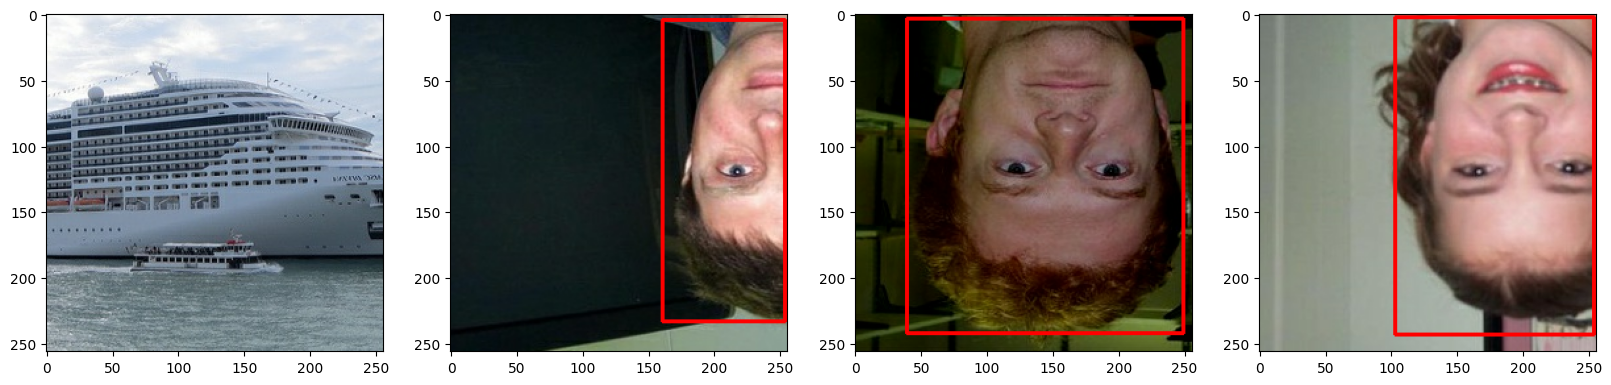

In [67]:
test_sample = test_data.next()
prediction = model.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = prediction[1][idx]
    
    if prediction[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [256,256]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [256,256]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [68]:
## model.save("model_1", save_format = "tf")

## Reflection
That worked pretty well, but I wonder if I can customize/improve it further.

***
***
## Model #2

#### Changes
- Decrease classification nodes: 2048 -> 512
- Increase regression layers: 2048 -> 2048/1024/512
- More epochs: 24 -> 64
- Smaller learning rate 0.0001 -> 0.00005

In [69]:
# Clear the previous model
keras.backend.clear_session()

In [70]:
batches_per_epoch = len(train)
learning_rate_decay = (1. / 0.75 - 1)/batches_per_epoch

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, decay = learning_rate_decay)

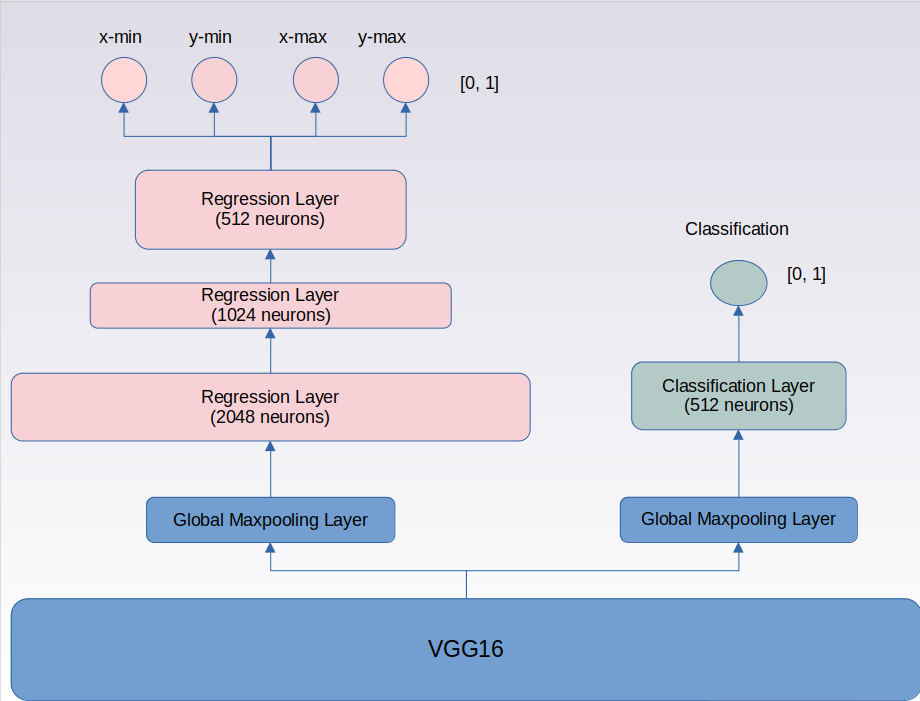

In [72]:
def build_model():
    
    input_layer = Input(shape = (256, 256, 3))
    # Using VGG16 here
    vgg16 = VGG16(include_top = False)(input_layer)
    
    
    # ============= Classification =======================================================
    condensing_layer_1 = GlobalMaxPooling2D()(vgg16)
    classification_layer_1 = Dense(512, activation = "relu")(condensing_layer_1)
    classification_output_layer = Dense(1, activation = "sigmoid")(classification_layer_1)
    
    
    # ============= Bounding Box Regression ==============================================
    condensing_layer_2 = GlobalMaxPooling2D()(vgg16)
    regression_layer_1 = Dense(2048, activation = "relu")(condensing_layer_2)
    regression_layer_2 = Dense(1024, activation = "relu")(regression_layer_1)
    regression_layer_3 = Dense(512, activation = "relu")(regression_layer_2)
    regression_output_layer = Dense(4, activation = "sigmoid")(regression_layer_3)
    
    
    
    myModel = Model(inputs = input_layer, outputs = [classification_output_layer, regression_output_layer])
    myModel.build(input_shape = (None, 256, 256, 3))
    return myModel


myModel = build_model()
myModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         1050624     global_max_pooling2d_1[0][0]     
______________________________________________________________________________________________

In [73]:
model_build_2 = FaceLocalizer(myModel)

In [74]:
model_build_2.compile(optimizer, 
              classification_loss = classification_loss, 
              localization_loss = localization_loss)

In [75]:
%%time
history = model_build_2.fit(train, 
                    validation_data = val, 
                    epochs = 64)

Epoch 1/64


2023-12-07 00:57:17.852913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3699 of 5000
2023-12-07 00:57:20.357710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 251ms/step - total_loss: 1.8478 - classification_loss: 0.1092 - localization_loss: 1.7932 - val_total_loss: 0.0380 - val_classification_loss: 0.0123 - val_localization_loss: 0.0318
Epoch 2/64


2023-12-07 00:58:09.004219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4201 of 5000
2023-12-07 00:58:10.472998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 265ms/step - total_loss: 0.3769 - classification_loss: 0.0109 - localization_loss: 0.3714 - val_total_loss: 0.1722 - val_classification_loss: 0.0012 - val_localization_loss: 0.1717
Epoch 3/64


2023-12-07 00:59:01.281202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3561 of 5000
2023-12-07 00:59:05.412272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 254ms/step - total_loss: 0.1877 - classification_loss: 0.0021 - localization_loss: 0.1866 - val_total_loss: 0.0072 - val_classification_loss: 0.0011 - val_localization_loss: 0.0066
Epoch 4/64


2023-12-07 00:59:54.491305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3807 of 5000
2023-12-07 00:59:57.020917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 251ms/step - total_loss: 0.1284 - classification_loss: 7.0651e-04 - localization_loss: 0.1280 - val_total_loss: 0.0072 - val_classification_loss: 5.6741e-04 - val_localization_loss: 0.0069
Epoch 5/64


2023-12-07 01:00:45.670943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3302 of 5000
2023-12-07 01:00:50.830966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 250ms/step - total_loss: 0.0989 - classification_loss: 4.1699e-04 - localization_loss: 0.0987 - val_total_loss: 0.1163 - val_classification_loss: 5.5561e-04 - val_localization_loss: 0.1161
Epoch 6/64


2023-12-07 01:01:39.319761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3227 of 5000
2023-12-07 01:01:45.184672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 246ms/step - total_loss: 0.0784 - classification_loss: 2.8778e-04 - localization_loss: 0.0783 - val_total_loss: 0.0042 - val_classification_loss: 1.4951e-04 - val_localization_loss: 0.0041
Epoch 7/64


2023-12-07 01:02:33.116341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3757 of 5000
2023-12-07 01:02:35.874574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 50s 244ms/step - total_loss: 0.0625 - classification_loss: 2.1032e-04 - localization_loss: 0.0624 - val_total_loss: 0.0010 - val_classification_loss: 1.5288e-04 - val_localization_loss: 9.3633e-04
Epoch 8/64


2023-12-07 01:03:23.523828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3090 of 5000
2023-12-07 01:03:29.402541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 249ms/step - total_loss: 0.0497 - classification_loss: 1.4971e-04 - localization_loss: 0.0496 - val_total_loss: 0.0064 - val_classification_loss: 3.2590e-05 - val_localization_loss: 0.0064
Epoch 9/64


2023-12-07 01:04:17.833834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3049 of 5000
2023-12-07 01:04:24.014726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 246ms/step - total_loss: 0.0413 - classification_loss: 1.1876e-04 - localization_loss: 0.0412 - val_total_loss: 0.0177 - val_classification_loss: 8.8195e-05 - val_localization_loss: 0.0176
Epoch 10/64


2023-12-07 01:05:11.933752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3060 of 5000
2023-12-07 01:05:16.585905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 250ms/step - total_loss: 0.0358 - classification_loss: 9.5092e-05 - localization_loss: 0.0358 - val_total_loss: 0.0113 - val_classification_loss: 1.6565e-04 - val_localization_loss: 0.0112
Epoch 11/64


2023-12-07 01:06:05.180457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3451 of 5000
2023-12-07 01:06:09.120581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 249ms/step - total_loss: 0.0304 - classification_loss: 8.8089e-05 - localization_loss: 0.0304 - val_total_loss: 0.0179 - val_classification_loss: 2.3887e-05 - val_localization_loss: 0.0179
Epoch 12/64


2023-12-07 01:06:57.461059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4505 of 5000
2023-12-07 01:06:58.343689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 49s 246ms/step - total_loss: 0.0255 - classification_loss: 7.1632e-05 - localization_loss: 0.0255 - val_total_loss: 0.0078 - val_classification_loss: 7.6735e-05 - val_localization_loss: 0.0078
Epoch 13/64


2023-12-07 01:07:46.245776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3574 of 5000
2023-12-07 01:07:49.987602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 259ms/step - total_loss: 0.0217 - classification_loss: 6.0545e-05 - localization_loss: 0.0216 - val_total_loss: 0.0121 - val_classification_loss: 1.2815e-05 - val_localization_loss: 0.0121
Epoch 14/64


2023-12-07 01:08:39.839303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2938 of 5000
2023-12-07 01:08:46.299522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 254ms/step - total_loss: 0.0199 - classification_loss: 5.1970e-05 - localization_loss: 0.0198 - val_total_loss: 5.2919e-04 - val_classification_loss: 1.0401e-05 - val_localization_loss: 5.2399e-04
Epoch 15/64


2023-12-07 01:09:35.501286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3553 of 5000
2023-12-07 01:09:38.656771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 254ms/step - total_loss: 0.0177 - classification_loss: 4.7561e-05 - localization_loss: 0.0177 - val_total_loss: 2.4767e-04 - val_classification_loss: 4.3971e-04 - val_localization_loss: 2.7817e-05
Epoch 16/64


2023-12-07 01:10:27.776828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3573 of 5000
2023-12-07 01:10:32.303391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 258ms/step - total_loss: 0.0158 - classification_loss: 4.2354e-05 - localization_loss: 0.0158 - val_total_loss: 0.1527 - val_classification_loss: 6.2662e-05 - val_localization_loss: 0.1527
Epoch 17/64


2023-12-07 01:11:22.040529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3528 of 5000
2023-12-07 01:11:25.475852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 258ms/step - total_loss: 0.0147 - classification_loss: 3.6584e-05 - localization_loss: 0.0147 - val_total_loss: 0.0105 - val_classification_loss: 9.4707e-05 - val_localization_loss: 0.0104
Epoch 18/64


2023-12-07 01:12:15.307602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4523 of 5000
2023-12-07 01:12:16.616395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 263ms/step - total_loss: 0.0147 - classification_loss: 3.7522e-05 - localization_loss: 0.0147 - val_total_loss: 0.0079 - val_classification_loss: 1.7971e-05 - val_localization_loss: 0.0079
Epoch 19/64


2023-12-07 01:13:07.216771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2998 of 5000
2023-12-07 01:13:13.540572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 261ms/step - total_loss: 0.0155 - classification_loss: 3.6286e-05 - localization_loss: 0.0154 - val_total_loss: 2.8014e-05 - val_classification_loss: 4.5956e-05 - val_localization_loss: 5.0355e-06
Epoch 20/64


2023-12-07 01:14:03.781121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3771 of 5000
2023-12-07 01:14:06.808757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 258ms/step - total_loss: 0.0146 - classification_loss: 3.4809e-05 - localization_loss: 0.0146 - val_total_loss: 0.0288 - val_classification_loss: 1.7301e-05 - val_localization_loss: 0.0288
Epoch 21/64


2023-12-07 01:14:56.630432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3556 of 5000
2023-12-07 01:15:00.200937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 268ms/step - total_loss: 0.0124 - classification_loss: 3.1397e-05 - localization_loss: 0.0124 - val_total_loss: 0.0162 - val_classification_loss: 7.7486e-07 - val_localization_loss: 0.0162
Epoch 22/64


2023-12-07 01:15:51.517726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3145 of 5000
2023-12-07 01:15:56.354424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 249ms/step - total_loss: 0.0113 - classification_loss: 3.0380e-05 - localization_loss: 0.0113 - val_total_loss: 0.0015 - val_classification_loss: 8.0318e-06 - val_localization_loss: 0.0015
Epoch 23/64


2023-12-07 01:16:44.739912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3517 of 5000
2023-12-07 01:16:49.274747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 255ms/step - total_loss: 0.0115 - classification_loss: 2.7192e-05 - localization_loss: 0.0115 - val_total_loss: 0.0187 - val_classification_loss: 8.9855e-06 - val_localization_loss: 0.0187
Epoch 24/64


2023-12-07 01:17:38.579045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3241 of 5000
2023-12-07 01:17:44.478527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 256ms/step - total_loss: 0.0126 - classification_loss: 3.1094e-05 - localization_loss: 0.0126 - val_total_loss: 0.0155 - val_classification_loss: 0.0026 - val_localization_loss: 0.0142
Epoch 25/64


2023-12-07 01:18:33.923763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2943 of 5000
2023-12-07 01:18:40.040691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 246ms/step - total_loss: 0.0108 - classification_loss: 2.7728e-05 - localization_loss: 0.0108 - val_total_loss: 0.0056 - val_classification_loss: 2.4111e-05 - val_localization_loss: 0.0056
Epoch 26/64


2023-12-07 01:19:27.975608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3012 of 5000
2023-12-07 01:19:33.289025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 245ms/step - total_loss: 0.0103 - classification_loss: 2.8124e-05 - localization_loss: 0.0103 - val_total_loss: 0.0157 - val_classification_loss: 4.4704e-07 - val_localization_loss: 0.0157
Epoch 27/64


2023-12-07 01:20:21.062078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3642 of 5000
2023-12-07 01:20:25.843480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 253ms/step - total_loss: 0.0092 - classification_loss: 2.3164e-05 - localization_loss: 0.0092 - val_total_loss: 0.0448 - val_classification_loss: 7.8333e-05 - val_localization_loss: 0.0448
Epoch 28/64


2023-12-07 01:21:14.829984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3695 of 5000
2023-12-07 01:21:17.861370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 249ms/step - total_loss: 0.0090 - classification_loss: 2.4567e-05 - localization_loss: 0.0090 - val_total_loss: 0.0207 - val_classification_loss: 6.3621e-05 - val_localization_loss: 0.0207
Epoch 29/64


2023-12-07 01:22:06.212644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3415 of 5000
2023-12-07 01:22:11.314405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 247ms/step - total_loss: 0.0085 - classification_loss: 2.1822e-05 - localization_loss: 0.0085 - val_total_loss: 0.0684 - val_classification_loss: 0.0025 - val_localization_loss: 0.0672
Epoch 30/64


2023-12-07 01:22:59.463353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3106 of 5000
2023-12-07 01:23:05.771758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 257ms/step - total_loss: 0.0081 - classification_loss: 1.9855e-05 - localization_loss: 0.0081 - val_total_loss: 0.0160 - val_classification_loss: 1.4007e-06 - val_localization_loss: 0.0160
Epoch 31/64


2023-12-07 01:23:55.410122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3446 of 5000
2023-12-07 01:24:00.598504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 245ms/step - total_loss: 0.0081 - classification_loss: 2.0379e-05 - localization_loss: 0.0081 - val_total_loss: 0.0091 - val_classification_loss: 1.4305e-06 - val_localization_loss: 0.0091
Epoch 32/64


2023-12-07 01:24:48.379364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3702 of 5000
2023-12-07 01:24:51.231424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 245ms/step - total_loss: 0.0087 - classification_loss: 1.9473e-05 - localization_loss: 0.0086 - val_total_loss: 0.0319 - val_classification_loss: 3.8743e-07 - val_localization_loss: 0.0319
Epoch 33/64


2023-12-07 01:25:39.072306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3101 of 5000
2023-12-07 01:25:46.011479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 241ms/step - total_loss: 0.0079 - classification_loss: 1.8154e-05 - localization_loss: 0.0079 - val_total_loss: 0.0299 - val_classification_loss: 1.4305e-06 - val_localization_loss: 0.0299
Epoch 34/64


2023-12-07 01:26:33.159633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3288 of 5000
2023-12-07 01:26:37.922206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 242ms/step - total_loss: 0.0076 - classification_loss: 1.9439e-05 - localization_loss: 0.0076 - val_total_loss: 0.0090 - val_classification_loss: 6.0797e-06 - val_localization_loss: 0.0090
Epoch 35/64


2023-12-07 01:27:25.247449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3624 of 5000
2023-12-07 01:27:30.542635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 246ms/step - total_loss: 0.0074 - classification_loss: 1.7485e-05 - localization_loss: 0.0074 - val_total_loss: 0.0326 - val_classification_loss: 2.5481e-06 - val_localization_loss: 0.0326
Epoch 36/64


2023-12-07 01:28:18.406530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3133 of 5000
2023-12-07 01:28:23.355378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 243ms/step - total_loss: 0.0072 - classification_loss: 1.7220e-05 - localization_loss: 0.0072 - val_total_loss: 0.0267 - val_classification_loss: 0.0010 - val_localization_loss: 0.0262
Epoch 37/64


2023-12-07 01:29:10.802521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2858 of 5000
2023-12-07 01:29:17.393230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 254ms/step - total_loss: 0.0076 - classification_loss: 1.5972e-05 - localization_loss: 0.0075 - val_total_loss: 0.0043 - val_classification_loss: 7.8228e-05 - val_localization_loss: 0.0042
Epoch 38/64


2023-12-07 01:30:06.619613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2841 of 5000
2023-12-07 01:30:13.341125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 245ms/step - total_loss: 0.0067 - classification_loss: 1.4935e-05 - localization_loss: 0.0067 - val_total_loss: 0.0150 - val_classification_loss: 7.4656e-06 - val_localization_loss: 0.0150
Epoch 39/64


2023-12-07 01:31:01.126138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2872 of 5000
2023-12-07 01:31:06.652651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 247ms/step - total_loss: 0.0063 - classification_loss: 1.4958e-05 - localization_loss: 0.0063 - val_total_loss: 0.0282 - val_classification_loss: 8.3699e-05 - val_localization_loss: 0.0282
Epoch 40/64


2023-12-07 01:31:54.812445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3325 of 5000
2023-12-07 01:32:00.133286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 248ms/step - total_loss: 0.0059 - classification_loss: 1.3638e-05 - localization_loss: 0.0059 - val_total_loss: 0.0200 - val_classification_loss: 3.1740e-06 - val_localization_loss: 0.0200
Epoch 41/64


2023-12-07 01:32:48.336419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3131 of 5000
2023-12-07 01:32:54.264942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.0057 - classification_loss: 1.4202e-05 - localization_loss: 0.0057 - val_total_loss: 0.0039 - val_classification_loss: 4.3411e-05 - val_localization_loss: 0.0039
Epoch 42/64


2023-12-07 01:33:41.758826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2893 of 5000
2023-12-07 01:33:47.708350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 246ms/step - total_loss: 0.0058 - classification_loss: 1.2858e-05 - localization_loss: 0.0058 - val_total_loss: 0.0151 - val_classification_loss: 5.2601e-06 - val_localization_loss: 0.0151
Epoch 43/64


2023-12-07 01:34:35.654527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3093 of 5000
2023-12-07 01:34:43.129031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 239ms/step - total_loss: 0.0058 - classification_loss: 1.2366e-05 - localization_loss: 0.0058 - val_total_loss: 0.0069 - val_classification_loss: 1.8955e-05 - val_localization_loss: 0.0069
Epoch 44/64


2023-12-07 01:35:29.980345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3153 of 5000
2023-12-07 01:35:34.664133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 248ms/step - total_loss: 0.0060 - classification_loss: 1.2048e-05 - localization_loss: 0.0060 - val_total_loss: 0.0037 - val_classification_loss: 5.2899e-06 - val_localization_loss: 0.0037
Epoch 45/64


2023-12-07 01:36:22.839890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2969 of 5000
2023-12-07 01:36:28.334655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 260ms/step - total_loss: 0.0061 - classification_loss: 1.2326e-05 - localization_loss: 0.0061 - val_total_loss: 0.0110 - val_classification_loss: 3.7104e-06 - val_localization_loss: 0.0110
Epoch 46/64


2023-12-07 01:37:18.340931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3258 of 5000
2023-12-07 01:37:24.504170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 252ms/step - total_loss: 0.0057 - classification_loss: 1.1568e-05 - localization_loss: 0.0057 - val_total_loss: 0.0111 - val_classification_loss: 2.0743e-05 - val_localization_loss: 0.0111
Epoch 47/64


2023-12-07 01:38:13.360628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3867 of 5000
2023-12-07 01:38:16.251897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 244ms/step - total_loss: 0.0052 - classification_loss: 1.1054e-05 - localization_loss: 0.0052 - val_total_loss: 0.0014 - val_classification_loss: 4.2022e-06 - val_localization_loss: 0.0014
Epoch 48/64


2023-12-07 01:39:03.928371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2920 of 5000
2023-12-07 01:39:10.512933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 247ms/step - total_loss: 0.0052 - classification_loss: 1.0631e-05 - localization_loss: 0.0052 - val_total_loss: 0.0310 - val_classification_loss: 0.0000e+00 - val_localization_loss: 0.0310
Epoch 49/64


2023-12-07 01:39:58.528016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3419 of 5000
2023-12-07 01:40:02.163431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 248ms/step - total_loss: 0.0052 - classification_loss: 9.8819e-06 - localization_loss: 0.0052 - val_total_loss: 0.0103 - val_classification_loss: 5.2154e-06 - val_localization_loss: 0.0103
Epoch 50/64


2023-12-07 01:40:50.388059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2970 of 5000
2023-12-07 01:40:57.693312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 244ms/step - total_loss: 0.0053 - classification_loss: 1.0397e-05 - localization_loss: 0.0053 - val_total_loss: 1.7643 - val_classification_loss: 1.9891 - val_localization_loss: 0.7698
Epoch 51/64


2023-12-07 01:41:45.285436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2927 of 5000
2023-12-07 01:41:49.908563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 253ms/step - total_loss: 0.0046 - classification_loss: 9.3484e-06 - localization_loss: 0.0046 - val_total_loss: 0.0115 - val_classification_loss: 1.5497e-06 - val_localization_loss: 0.0115
Epoch 52/64


2023-12-07 01:42:38.905113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3258 of 5000
2023-12-07 01:42:43.308357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 245ms/step - total_loss: 0.0043 - classification_loss: 9.0642e-06 - localization_loss: 0.0043 - val_total_loss: 0.0025 - val_classification_loss: 1.6570e-05 - val_localization_loss: 0.0025
Epoch 53/64


2023-12-07 01:43:31.098965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3250 of 5000
2023-12-07 01:43:36.176928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 255ms/step - total_loss: 0.0042 - classification_loss: 8.2619e-06 - localization_loss: 0.0042 - val_total_loss: 0.0390 - val_classification_loss: 7.7486e-07 - val_localization_loss: 0.0390
Epoch 54/64


2023-12-07 01:44:25.434736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3179 of 5000
2023-12-07 01:44:31.019318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 261ms/step - total_loss: 0.0040 - classification_loss: 7.8279e-06 - localization_loss: 0.0040 - val_total_loss: 0.0323 - val_classification_loss: 1.5646e-06 - val_localization_loss: 0.0323
Epoch 55/64


2023-12-07 01:45:21.281997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3666 of 5000
2023-12-07 01:45:24.412175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 255ms/step - total_loss: 0.0040 - classification_loss: 7.4054e-06 - localization_loss: 0.0040 - val_total_loss: 0.0073 - val_classification_loss: 1.7881e-07 - val_localization_loss: 0.0073
Epoch 56/64


2023-12-07 01:46:13.726160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3080 of 5000
2023-12-07 01:46:19.643164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 254ms/step - total_loss: 0.0042 - classification_loss: 7.2461e-06 - localization_loss: 0.0042 - val_total_loss: 0.0132 - val_classification_loss: 5.5582e-06 - val_localization_loss: 0.0132
Epoch 57/64


2023-12-07 01:47:08.743927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3205 of 5000
2023-12-07 01:47:14.239698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 254ms/step - total_loss: 0.0046 - classification_loss: 7.2638e-06 - localization_loss: 0.0046 - val_total_loss: 0.0096 - val_classification_loss: 1.2517e-05 - val_localization_loss: 0.0096
Epoch 58/64


2023-12-07 01:48:03.439843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2857 of 5000
2023-12-07 01:48:08.767924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.0045 - classification_loss: 7.1429e-06 - localization_loss: 0.0045 - val_total_loss: 0.0118 - val_classification_loss: 1.4876e-04 - val_localization_loss: 0.0117
Epoch 59/64


2023-12-07 01:48:56.236666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3157 of 5000
2023-12-07 01:49:00.991166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 257ms/step - total_loss: 0.0038 - classification_loss: 6.7417e-06 - localization_loss: 0.0038 - val_total_loss: 0.0256 - val_classification_loss: 2.2948e-06 - val_localization_loss: 0.0256
Epoch 60/64


2023-12-07 01:49:50.577677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3044 of 5000
2023-12-07 01:49:55.366970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 256ms/step - total_loss: 0.0037 - classification_loss: 6.0299e-06 - localization_loss: 0.0037 - val_total_loss: 0.0143 - val_classification_loss: 5.3644e-07 - val_localization_loss: 0.0143
Epoch 61/64


2023-12-07 01:50:44.753406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3155 of 5000
2023-12-07 01:50:50.834167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 252ms/step - total_loss: 0.0034 - classification_loss: 6.0012e-06 - localization_loss: 0.0034 - val_total_loss: 0.0290 - val_classification_loss: 2.1507e-04 - val_localization_loss: 0.0289
Epoch 62/64


2023-12-07 01:51:39.654287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3965 of 5000
2023-12-07 01:51:42.484247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 254ms/step - total_loss: 0.0035 - classification_loss: 6.0241e-06 - localization_loss: 0.0035 - val_total_loss: 0.0241 - val_classification_loss: 2.5332e-07 - val_localization_loss: 0.0241
Epoch 63/64


2023-12-07 01:52:31.618217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3698 of 5000
2023-12-07 01:52:35.573333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 242ms/step - total_loss: 0.0035 - classification_loss: 5.2185e-06 - localization_loss: 0.0035 - val_total_loss: 0.0037 - val_classification_loss: 1.1921e-07 - val_localization_loss: 0.0037
Epoch 64/64


2023-12-07 01:53:22.885190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3030 of 5000
2023-12-07 01:53:29.368914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 245ms/step - total_loss: 0.0032 - classification_loss: 5.0022e-06 - localization_loss: 0.0032 - val_total_loss: 0.0098 - val_classification_loss: 4.7982e-06 - val_localization_loss: 0.0098
CPU times: user 50min 23s, sys: 3min 36s, total: 53min 59s
Wall time: 57min


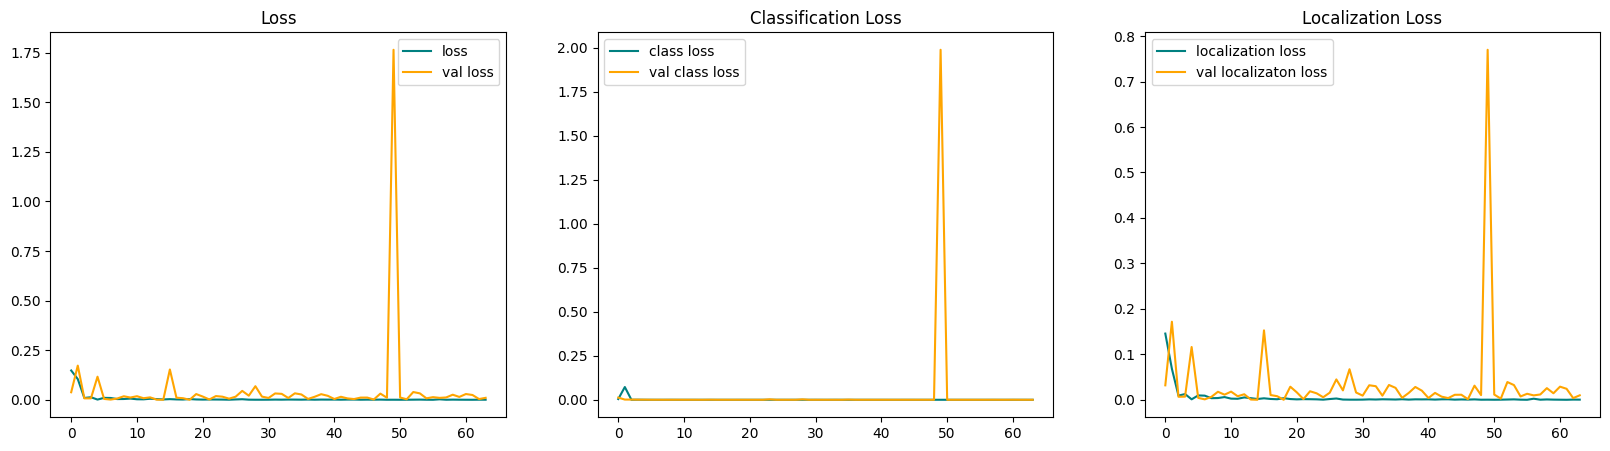

In [76]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['localization_loss'], color='teal', label='localization loss')
ax[2].plot(history.history['val_localization_loss'], color='orange', label='val localizaton loss')
ax[2].title.set_text('Localization Loss')
ax[2].legend()

plt.show()

In [77]:
 model.save("model_2", save_format = "tf")

2023-12-07 01:54:08.608797: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_2/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


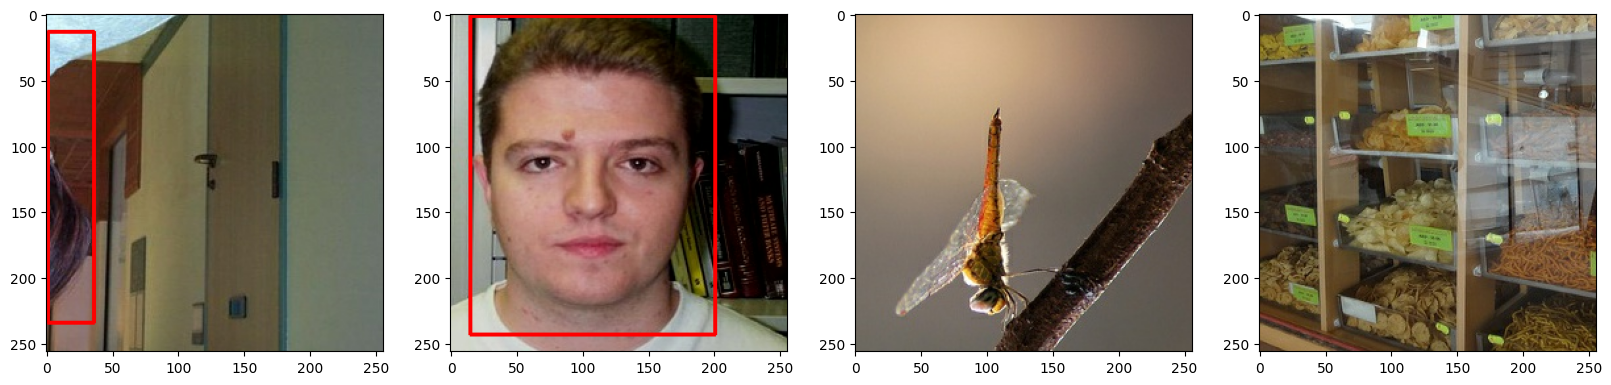

In [78]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

# Using model_build_2 now instead
prediction = model_build_2.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = prediction[1][idx]
    
    if prediction[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [256,256]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [256,256]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

***
***
## Model #3

#### Changes
- Less learning rate decay: (1/0.75 - 1) -> (1/0.8 - 1) |  0.3333 -> 0.25
- Loss function weighed differently: classification now matters even less: 0.5 -> 0.15
- Learning rate back up to 0.0001

In [79]:
# Clear the previous model
keras.backend.clear_session()

In [80]:
batches_per_epoch = len(train)
learning_rate_decay = (1. / 0.8 - 1)/batches_per_epoch
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = learning_rate_decay)

In [81]:
def localization_loss(y_true, y_predicted):
    
    delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - y_predicted[:,:2]))
    # print("delta_coords = ", delta_coords)
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    # print("h_true = ", h_true)
    # print("w_true = ", w_true)
    
    h_predicted = y_predicted[:,3] - y_predicted[:,1]
    w_predicted = y_predicted[:,2] - y_predicted[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_predicted) + tf.square(h_true - h_predicted))
    
    return delta_coords + delta_size

In [82]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
localization_loss = localization_loss

In [83]:
def build_model():
    
    input_layer = Input(shape = (256, 256, 3))
    # Using VGG16 here
    vgg16 = VGG16(include_top = False)(input_layer)
    
    
    # ============= Classification =======================================================
    condensing_layer_1 = GlobalMaxPooling2D()(vgg16)
    classification_layer_1 = Dense(512, activation = "relu")(condensing_layer_1)
    classification_output_layer = Dense(1, activation = "sigmoid")(classification_layer_1)
    
    
    # ============= Bounding Box Regression ==============================================
    condensing_layer_2 = GlobalMaxPooling2D()(vgg16)
    regression_layer_1 = Dense(2048, activation = "relu")(condensing_layer_2)
    regression_layer_2 = Dense(1024, activation = "relu")(regression_layer_1)
    regression_layer_3 = Dense(512, activation = "relu")(regression_layer_2)
    regression_output_layer = Dense(4, activation = "sigmoid")(regression_layer_3)
    
    
    
    myModel = Model(inputs = input_layer, outputs = [classification_output_layer, regression_output_layer])
    myModel.build(input_shape = (None, 256, 256, 3))
    return myModel

In [84]:
newModel = build_model()
newModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         1050624     global_max_pooling2d_1[0][0]     
______________________________________________________________________________________________

In [85]:
class FaceLocalizer3(Model):
    def __init__(self, myModel, **kwargs):
        super().__init__(**kwargs)
        self.model = myModel
        
    def compile(self, optimizer, classification_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.localization_loss = localization_loss
        self.optimizer = optimizer
    
    # One batch at a time, of course
    def train_step(self, batch, **kwargs):
        # X = image
        # y = labels
        # y[0] = classes, y[1] = bounding box coordinates
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction from the model by passing through an image
            classes, coords = self.model(X, training = True)
            
            # Calculate losses
            batch_classification_loss = self.classification_loss(y[0], classes)
            batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
            
            # Could change how this is calculated - Chagning it from 0.5 to 0.15, making it "matter" even less
            total_loss = batch_localization_loss + 0.15 * batch_classification_loss
            
            gradient = tape.gradient(total_loss, self.model.trainable_variables)
            
        # This is actually the back propagation
        optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training = False)
        
        batch_classification_loss = self.classification_loss(y[0], classes)
        batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localization_loss + 0.5 * batch_classification_loss
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
        
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [86]:
model_build_3 = FaceLocalizer3(newModel)

In [87]:
model_build_3.compile(optimizer, 
              classification_loss = classification_loss, 
              localization_loss = localization_loss)

In [88]:
%%time
history = model_build_3.fit(train, 
                    validation_data = val, 
                    epochs = 64)

Epoch 1/64


2023-12-07 01:54:26.540712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3980 of 5000
2023-12-07 01:54:28.736820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 259ms/step - total_loss: 2.0604 - classification_loss: 0.1122 - localization_loss: 2.0436 - val_total_loss: 0.0229 - val_classification_loss: 0.0041 - val_localization_loss: 0.0209
Epoch 2/64


2023-12-07 01:55:18.667188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3153 of 5000
2023-12-07 01:55:21.472194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 266ms/step - total_loss: 0.5758 - classification_loss: 0.0224 - localization_loss: 0.5725 - val_total_loss: 0.0412 - val_classification_loss: 3.2526e-04 - val_localization_loss: 0.0410
Epoch 3/64


2023-12-07 01:56:12.431049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3375 of 5000
2023-12-07 01:56:17.529802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 240ms/step - total_loss: 0.3251 - classification_loss: 0.0127 - localization_loss: 0.3232 - val_total_loss: 0.0315 - val_classification_loss: 0.0015 - val_localization_loss: 0.0307
Epoch 4/64


2023-12-07 01:57:04.628514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3099 of 5000
2023-12-07 01:57:10.957643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 248ms/step - total_loss: 0.1894 - classification_loss: 0.0032 - localization_loss: 0.1889 - val_total_loss: 0.0178 - val_classification_loss: 2.0139e-04 - val_localization_loss: 0.0177
Epoch 5/64


2023-12-07 01:57:59.226133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3051 of 5000
2023-12-07 01:58:05.195629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 253ms/step - total_loss: 0.1640 - classification_loss: 0.0036 - localization_loss: 0.1635 - val_total_loss: 0.0517 - val_classification_loss: 0.0015 - val_localization_loss: 0.0509
Epoch 6/64


2023-12-07 01:58:54.183378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2875 of 5000
2023-12-07 01:59:00.690046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 244ms/step - total_loss: 0.1062 - classification_loss: 5.6941e-04 - localization_loss: 0.1061 - val_total_loss: 0.0169 - val_classification_loss: 1.2650e-04 - val_localization_loss: 0.0169
Epoch 7/64


2023-12-07 01:59:48.288509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3347 of 5000
2023-12-07 01:59:52.752931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 247ms/step - total_loss: 0.0837 - classification_loss: 3.2528e-04 - localization_loss: 0.0836 - val_total_loss: 5.1970e-05 - val_classification_loss: 1.0051e-04 - val_localization_loss: 1.7129e-06
Epoch 8/64


2023-12-07 02:00:40.809830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2883 of 5000
2023-12-07 02:00:47.617299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 246ms/step - total_loss: 0.0691 - classification_loss: 2.9632e-04 - localization_loss: 0.0691 - val_total_loss: 0.0267 - val_classification_loss: 2.3232e-05 - val_localization_loss: 0.0267
Epoch 9/64


2023-12-07 02:01:35.572725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3113 of 5000
2023-12-07 02:01:41.191775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 246ms/step - total_loss: 0.0579 - classification_loss: 2.3331e-04 - localization_loss: 0.0579 - val_total_loss: 0.0021 - val_classification_loss: 1.0476e-05 - val_localization_loss: 0.0021
Epoch 10/64


2023-12-07 02:02:29.105208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3023 of 5000
2023-12-07 02:02:35.062933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 245ms/step - total_loss: 0.0482 - classification_loss: 1.9034e-04 - localization_loss: 0.0482 - val_total_loss: 0.0088 - val_classification_loss: 3.3485e-05 - val_localization_loss: 0.0088
Epoch 11/64


2023-12-07 02:03:22.877275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2857 of 5000
2023-12-07 02:03:30.240911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 248ms/step - total_loss: 0.0393 - classification_loss: 1.6269e-04 - localization_loss: 0.0393 - val_total_loss: 0.0175 - val_classification_loss: 7.9818e-05 - val_localization_loss: 0.0175
Epoch 12/64


2023-12-07 02:04:18.538002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2847 of 5000
2023-12-07 02:04:26.350061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 251ms/step - total_loss: 0.0334 - classification_loss: 1.3204e-04 - localization_loss: 0.0334 - val_total_loss: 4.8437e-04 - val_classification_loss: 1.6213e-05 - val_localization_loss: 4.7626e-04
Epoch 13/64


2023-12-07 02:05:14.984865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3660 of 5000
2023-12-07 02:05:18.329892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 255ms/step - total_loss: 0.0269 - classification_loss: 1.0903e-04 - localization_loss: 0.0269 - val_total_loss: 0.0092 - val_classification_loss: 3.2783e-07 - val_localization_loss: 0.0092
Epoch 14/64


2023-12-07 02:06:07.572352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2940 of 5000
2023-12-07 02:06:14.727088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 247ms/step - total_loss: 0.0248 - classification_loss: 9.4549e-05 - localization_loss: 0.0248 - val_total_loss: 0.0080 - val_classification_loss: 2.5593e-04 - val_localization_loss: 0.0079
Epoch 15/64


2023-12-07 02:07:02.770191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2647 of 5000
2023-12-07 02:07:09.585002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 246ms/step - total_loss: 0.0206 - classification_loss: 8.6190e-05 - localization_loss: 0.0206 - val_total_loss: 0.0075 - val_classification_loss: 8.3447e-07 - val_localization_loss: 0.0075
Epoch 16/64


2023-12-07 02:07:57.429301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3531 of 5000
2023-12-07 02:08:01.466208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 245ms/step - total_loss: 0.0181 - classification_loss: 7.7138e-05 - localization_loss: 0.0180 - val_total_loss: 0.0191 - val_classification_loss: 8.9407e-08 - val_localization_loss: 0.0191
Epoch 17/64


2023-12-07 02:08:49.250942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3007 of 5000
2023-12-07 02:08:55.640357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 243ms/step - total_loss: 0.0172 - classification_loss: 7.0083e-05 - localization_loss: 0.0172 - val_total_loss: 0.0132 - val_classification_loss: 7.0358e-05 - val_localization_loss: 0.0131
Epoch 18/64


2023-12-07 02:09:43.101119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2897 of 5000
2023-12-07 02:09:50.549937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 244ms/step - total_loss: 0.0158 - classification_loss: 6.5150e-05 - localization_loss: 0.0158 - val_total_loss: 0.0204 - val_classification_loss: 1.1506e-04 - val_localization_loss: 0.0203
Epoch 19/64


2023-12-07 02:10:38.213677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3601 of 5000
2023-12-07 02:10:42.646760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 244ms/step - total_loss: 0.0137 - classification_loss: 5.4996e-05 - localization_loss: 0.0137 - val_total_loss: 0.0018 - val_classification_loss: 2.1742e-04 - val_localization_loss: 0.0017
Epoch 20/64


2023-12-07 02:11:30.247343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2735 of 5000
2023-12-07 02:11:38.108072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 238ms/step - total_loss: 0.0126 - classification_loss: 5.0824e-05 - localization_loss: 0.0126 - val_total_loss: 0.0100 - val_classification_loss: 2.3693e-06 - val_localization_loss: 0.0100
Epoch 21/64


2023-12-07 02:12:24.892439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3138 of 5000
2023-12-07 02:12:30.393686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 247ms/step - total_loss: 0.0119 - classification_loss: 4.9335e-05 - localization_loss: 0.0119 - val_total_loss: 0.0086 - val_classification_loss: 5.0639e-05 - val_localization_loss: 0.0085
Epoch 22/64


2023-12-07 02:13:18.485998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4530 of 5000
2023-12-07 02:13:19.457625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 50s 252ms/step - total_loss: 0.0122 - classification_loss: 4.0773e-05 - localization_loss: 0.0122 - val_total_loss: 0.0139 - val_classification_loss: 6.0413e-04 - val_localization_loss: 0.0136
Epoch 23/64


2023-12-07 02:14:08.352888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3046 of 5000
2023-12-07 02:14:13.417259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 252ms/step - total_loss: 0.0105 - classification_loss: 4.0053e-05 - localization_loss: 0.0104 - val_total_loss: 0.0059 - val_classification_loss: 8.5760e-04 - val_localization_loss: 0.0055
Epoch 24/64


2023-12-07 02:15:02.289726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3148 of 5000
2023-12-07 02:15:06.570441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 248ms/step - total_loss: 0.0094 - classification_loss: 3.6632e-05 - localization_loss: 0.0094 - val_total_loss: 0.0174 - val_classification_loss: 4.4767e-05 - val_localization_loss: 0.0174
Epoch 25/64


2023-12-07 02:15:54.791137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3262 of 5000
2023-12-07 02:16:00.571508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 255ms/step - total_loss: 0.0095 - classification_loss: 3.5454e-05 - localization_loss: 0.0095 - val_total_loss: 0.0051 - val_classification_loss: 8.4696e-05 - val_localization_loss: 0.0051
Epoch 26/64


2023-12-07 02:16:49.893375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3702 of 5000
2023-12-07 02:16:53.808554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 246ms/step - total_loss: 0.0094 - classification_loss: 3.5661e-05 - localization_loss: 0.0093 - val_total_loss: 0.0082 - val_classification_loss: 2.5332e-07 - val_localization_loss: 0.0082
Epoch 27/64


2023-12-07 02:17:41.651906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3405 of 5000
2023-12-07 02:17:46.202037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 241ms/step - total_loss: 0.0083 - classification_loss: 3.0613e-05 - localization_loss: 0.0083 - val_total_loss: 0.0112 - val_classification_loss: 2.9802e-07 - val_localization_loss: 0.0112
Epoch 28/64


2023-12-07 02:18:33.422732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2958 of 5000
2023-12-07 02:18:40.329902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 246ms/step - total_loss: 0.0079 - classification_loss: 2.8154e-05 - localization_loss: 0.0079 - val_total_loss: 0.0148 - val_classification_loss: 1.0525e-04 - val_localization_loss: 0.0147
Epoch 29/64


2023-12-07 02:19:28.225301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3202 of 5000
2023-12-07 02:19:33.579702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.0085 - classification_loss: 2.8468e-05 - localization_loss: 0.0085 - val_total_loss: 0.0092 - val_classification_loss: 1.7881e-07 - val_localization_loss: 0.0092
Epoch 30/64


2023-12-07 02:20:21.017807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3544 of 5000
2023-12-07 02:20:25.754246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 249ms/step - total_loss: 0.0076 - classification_loss: 2.7178e-05 - localization_loss: 0.0076 - val_total_loss: 0.0052 - val_classification_loss: 9.5368e-07 - val_localization_loss: 0.0052
Epoch 31/64


2023-12-07 02:21:14.104576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2834 of 5000
2023-12-07 02:21:20.225476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 258ms/step - total_loss: 0.0072 - classification_loss: 2.6072e-05 - localization_loss: 0.0072 - val_total_loss: 0.0075 - val_classification_loss: 1.8723e-04 - val_localization_loss: 0.0074
Epoch 32/64


2023-12-07 02:22:10.021186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3465 of 5000
2023-12-07 02:22:14.914923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 249ms/step - total_loss: 0.0089 - classification_loss: 2.6932e-05 - localization_loss: 0.0089 - val_total_loss: 0.0344 - val_classification_loss: 5.1936e-05 - val_localization_loss: 0.0344
Epoch 33/64


2023-12-07 02:23:03.340619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3447 of 5000
2023-12-07 02:23:07.110884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 259ms/step - total_loss: 0.0082 - classification_loss: 2.6867e-05 - localization_loss: 0.0082 - val_total_loss: 0.1392 - val_classification_loss: 0.1334 - val_localization_loss: 0.0725
Epoch 34/64


2023-12-07 02:23:57.067554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3211 of 5000
2023-12-07 02:24:02.328906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 246ms/step - total_loss: 0.0073 - classification_loss: 2.4901e-05 - localization_loss: 0.0073 - val_total_loss: 0.0074 - val_classification_loss: 9.6859e-06 - val_localization_loss: 0.0074
Epoch 35/64


2023-12-07 02:24:50.176208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3037 of 5000
2023-12-07 02:24:57.283352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 240ms/step - total_loss: 0.0071 - classification_loss: 2.4015e-05 - localization_loss: 0.0071 - val_total_loss: 0.0140 - val_classification_loss: 1.0923e-05 - val_localization_loss: 0.0140
Epoch 36/64


2023-12-07 02:25:44.285990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3323 of 5000
2023-12-07 02:25:49.912159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 245ms/step - total_loss: 0.0067 - classification_loss: 2.3417e-05 - localization_loss: 0.0067 - val_total_loss: 0.0325 - val_classification_loss: 2.6822e-06 - val_localization_loss: 0.0325
Epoch 37/64


2023-12-07 02:26:37.661482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3151 of 5000
2023-12-07 02:26:43.399019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 250ms/step - total_loss: 0.0059 - classification_loss: 2.1014e-05 - localization_loss: 0.0059 - val_total_loss: 0.0099 - val_classification_loss: 4.5896e-06 - val_localization_loss: 0.0099
Epoch 38/64


2023-12-07 02:27:31.886900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2848 of 5000
2023-12-07 02:27:38.428875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 247ms/step - total_loss: 0.0060 - classification_loss: 1.8951e-05 - localization_loss: 0.0060 - val_total_loss: 0.0304 - val_classification_loss: 8.5087e-06 - val_localization_loss: 0.0304
Epoch 39/64


2023-12-07 02:28:26.526879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3149 of 5000
2023-12-07 02:28:32.551425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 257ms/step - total_loss: 0.0056 - classification_loss: 1.9524e-05 - localization_loss: 0.0056 - val_total_loss: 4.8443e-04 - val_classification_loss: 1.0431e-05 - val_localization_loss: 4.7922e-04
Epoch 40/64


2023-12-07 02:29:22.140717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3026 of 5000
2023-12-07 02:29:29.192496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 237ms/step - total_loss: 0.0052 - classification_loss: 1.9196e-05 - localization_loss: 0.0052 - val_total_loss: 0.0019 - val_classification_loss: 4.0802e-05 - val_localization_loss: 0.0019
Epoch 41/64


2023-12-07 02:30:15.760636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3006 of 5000
2023-12-07 02:30:21.926421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 251ms/step - total_loss: 0.0052 - classification_loss: 1.7697e-05 - localization_loss: 0.0052 - val_total_loss: 0.0325 - val_classification_loss: 7.7313e-05 - val_localization_loss: 0.0325
Epoch 42/64


2023-12-07 02:31:10.673278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2943 of 5000
2023-12-07 02:31:17.420179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 249ms/step - total_loss: 0.0064 - classification_loss: 1.7533e-05 - localization_loss: 0.0064 - val_total_loss: 0.0066 - val_classification_loss: 2.5437e-05 - val_localization_loss: 0.0066
Epoch 43/64


2023-12-07 02:32:05.900415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3127 of 5000
2023-12-07 02:32:11.163461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 245ms/step - total_loss: 0.0062 - classification_loss: 1.7659e-05 - localization_loss: 0.0062 - val_total_loss: 0.0088 - val_classification_loss: 5.9605e-06 - val_localization_loss: 0.0088
Epoch 44/64


2023-12-07 02:32:58.975512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3320 of 5000
2023-12-07 02:33:03.535868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 250ms/step - total_loss: 0.0056 - classification_loss: 1.6479e-05 - localization_loss: 0.0056 - val_total_loss: 0.0087 - val_classification_loss: 4.8984e-05 - val_localization_loss: 0.0087
Epoch 45/64


2023-12-07 02:33:52.015568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3344 of 5000
2023-12-07 02:33:55.943078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 259ms/step - total_loss: 0.0052 - classification_loss: 1.5671e-05 - localization_loss: 0.0052 - val_total_loss: 0.0061 - val_classification_loss: 6.1990e-06 - val_localization_loss: 0.0061
Epoch 46/64


2023-12-07 02:34:45.862384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3106 of 5000
2023-12-07 02:34:52.651064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 243ms/step - total_loss: 0.0047 - classification_loss: 1.5731e-05 - localization_loss: 0.0047 - val_total_loss: 0.0279 - val_classification_loss: 5.7432e-05 - val_localization_loss: 0.0279
Epoch 47/64


2023-12-07 02:35:40.227117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3465 of 5000
2023-12-07 02:35:43.884133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 252ms/step - total_loss: 0.0044 - classification_loss: 1.4048e-05 - localization_loss: 0.0044 - val_total_loss: 0.0052 - val_classification_loss: 2.0982e-04 - val_localization_loss: 0.0051
Epoch 48/64


2023-12-07 02:36:32.783524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3594 of 5000
2023-12-07 02:36:36.432921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 259ms/step - total_loss: 0.0044 - classification_loss: 1.3824e-05 - localization_loss: 0.0044 - val_total_loss: 0.0182 - val_classification_loss: 4.4704e-07 - val_localization_loss: 0.0182
Epoch 49/64


2023-12-07 02:37:26.318960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3263 of 5000
2023-12-07 02:37:31.055718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 245ms/step - total_loss: 0.0047 - classification_loss: 1.3387e-05 - localization_loss: 0.0047 - val_total_loss: 0.0383 - val_classification_loss: 1.3247e-05 - val_localization_loss: 0.0383
Epoch 50/64


2023-12-07 02:38:18.773627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3114 of 5000
2023-12-07 02:38:23.760843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 239ms/step - total_loss: 0.0048 - classification_loss: 1.2834e-05 - localization_loss: 0.0048 - val_total_loss: 4.1996e-04 - val_classification_loss: 5.6624e-07 - val_localization_loss: 4.1967e-04
Epoch 51/64


2023-12-07 02:39:10.559321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3269 of 5000
2023-12-07 02:39:16.613764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.0045 - classification_loss: 1.3257e-05 - localization_loss: 0.0045 - val_total_loss: 6.9318e-04 - val_classification_loss: 9.4176e-06 - val_localization_loss: 6.8847e-04
Epoch 52/64


2023-12-07 02:40:04.044471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2739 of 5000
2023-12-07 02:40:11.125761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 247ms/step - total_loss: 0.0043 - classification_loss: 1.2059e-05 - localization_loss: 0.0043 - val_total_loss: 0.0025 - val_classification_loss: 1.5647e-05 - val_localization_loss: 0.0024
Epoch 53/64


2023-12-07 02:40:59.185151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3325 of 5000
2023-12-07 02:41:04.204322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 245ms/step - total_loss: 0.0054 - classification_loss: 1.0685e-05 - localization_loss: 0.0054 - val_total_loss: 0.0171 - val_classification_loss: 2.6822e-07 - val_localization_loss: 0.0171
Epoch 54/64


2023-12-07 02:41:52.033297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3548 of 5000
2023-12-07 02:41:57.137664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 246ms/step - total_loss: 0.0058 - classification_loss: 1.2526e-05 - localization_loss: 0.0058 - val_total_loss: 0.0247 - val_classification_loss: 1.9819e-06 - val_localization_loss: 0.0247
Epoch 55/64


2023-12-07 02:42:45.087898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3925 of 5000
2023-12-07 02:42:48.990700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 239ms/step - total_loss: 0.0051 - classification_loss: 1.2041e-05 - localization_loss: 0.0051 - val_total_loss: 0.0086 - val_classification_loss: 6.7801e-06 - val_localization_loss: 0.0086
Epoch 56/64


2023-12-07 02:43:35.850135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3286 of 5000
2023-12-07 02:43:40.091947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 260ms/step - total_loss: 0.0043 - classification_loss: 9.8389e-06 - localization_loss: 0.0043 - val_total_loss: 0.0019 - val_classification_loss: 1.0878e-05 - val_localization_loss: 0.0019
Epoch 57/64


2023-12-07 02:44:30.093035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3098 of 5000
2023-12-07 02:44:36.647175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 244ms/step - total_loss: 0.0038 - classification_loss: 1.0466e-05 - localization_loss: 0.0038 - val_total_loss: 0.0318 - val_classification_loss: 1.4901e-08 - val_localization_loss: 0.0318
Epoch 58/64


2023-12-07 02:45:24.266266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3408 of 5000
2023-12-07 02:45:28.831141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 255ms/step - total_loss: 0.0033 - classification_loss: 9.8651e-06 - localization_loss: 0.0033 - val_total_loss: 0.0080 - val_classification_loss: 4.0680e-06 - val_localization_loss: 0.0080
Epoch 59/64


2023-12-07 02:46:18.196778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3438 of 5000
2023-12-07 02:46:22.435686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 257ms/step - total_loss: 0.0027 - classification_loss: 8.4893e-06 - localization_loss: 0.0027 - val_total_loss: 0.0055 - val_classification_loss: 5.8115e-06 - val_localization_loss: 0.0055
Epoch 60/64


2023-12-07 02:47:12.025316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3471 of 5000
2023-12-07 02:47:15.820130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 247ms/step - total_loss: 0.0025 - classification_loss: 7.6774e-06 - localization_loss: 0.0025 - val_total_loss: 0.0058 - val_classification_loss: 1.7881e-06 - val_localization_loss: 0.0058
Epoch 61/64


2023-12-07 02:48:03.819623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3083 of 5000
2023-12-07 02:48:10.212512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 247ms/step - total_loss: 0.0028 - classification_loss: 7.6624e-06 - localization_loss: 0.0028 - val_total_loss: 0.0106 - val_classification_loss: 9.9691e-06 - val_localization_loss: 0.0106
Epoch 62/64


2023-12-07 02:48:58.210170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3073 of 5000
2023-12-07 02:49:04.229338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 252ms/step - total_loss: 0.0030 - classification_loss: 7.0482e-06 - localization_loss: 0.0030 - val_total_loss: 0.0034 - val_classification_loss: 1.5199e-06 - val_localization_loss: 0.0034
Epoch 63/64


2023-12-07 02:49:53.040819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3025 of 5000
2023-12-07 02:49:59.700011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 243ms/step - total_loss: 0.0031 - classification_loss: 6.8078e-06 - localization_loss: 0.0031 - val_total_loss: 0.0046 - val_classification_loss: 1.5646e-06 - val_localization_loss: 0.0046
Epoch 64/64


2023-12-07 02:50:47.233887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3350 of 5000
2023-12-07 02:50:51.494274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 238ms/step - total_loss: 0.0034 - classification_loss: 6.6386e-06 - localization_loss: 0.0034 - val_total_loss: 0.0065 - val_classification_loss: 4.4703e-08 - val_localization_loss: 0.0065
CPU times: user 50min 49s, sys: 3min 22s, total: 54min 12s
Wall time: 57min 12s


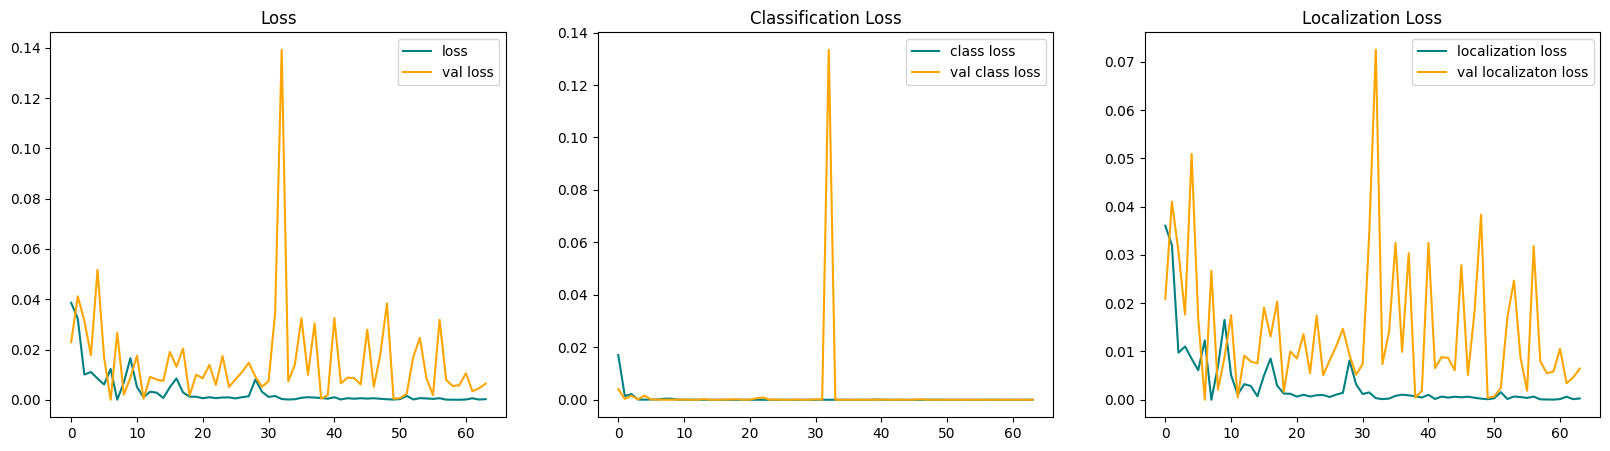

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['localization_loss'], color='teal', label='localization loss')
ax[2].plot(history.history['val_localization_loss'], color='orange', label='val localizaton loss')
ax[2].title.set_text('Localization Loss')
ax[2].legend()

plt.show()

In [90]:
model_build_3.compute_output_shape(input_shape = (None, 256, 256, 3))
model_build_3.save("model_3", save_format = "tf")

INFO:tensorflow:Assets written to: model_3/assets


***
## Model #4
So, I've read that too many hidden layers can make a model overfit, so let's try something else...
- Reducing layers
- Adding dropout

In [91]:
# Clear the previous model
keras.backend.clear_session()

In [92]:
def build_model():
    
    input_layer = Input(shape = (256, 256, 3))
    # Using VGG16 here
    vgg16 = VGG16(include_top = False)(input_layer)
    
    
    # ============= Classification =======================================================
    condensing_layer_1 = GlobalMaxPooling2D()(vgg16)
    classification_layer_1 = Dense(512, activation = "relu")(condensing_layer_1)
    classification_output_layer = Dense(1, activation = "sigmoid")(classification_layer_1)
    
    
    # ============= Bounding Box Regression ==============================================
    condensing_layer_2 = GlobalMaxPooling2D()(vgg16)
    regression_layer_1 = Dense(1024, activation = "relu")(condensing_layer_2)
    dropout_layer_1 = Dropout(0.5)(regression_layer_1)
    regression_layer_2 = Dense(128, activation = "relu")(dropout_layer_1)
    regression_output_layer = Dense(4, activation = "sigmoid")(regression_layer_2)
    
    
    
    myModel = Model(inputs = input_layer, outputs = [classification_output_layer, regression_output_layer])
    myModel.build(input_shape = (None, 256, 256, 3))
    return myModel

In [93]:
newModel = build_model()
newModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         525312      global_max_pooling2d_1[0][0]     
______________________________________________________________________________________________

In [94]:
# Still using "3"

model_build_4 = FaceLocalizer3(newModel)

In [95]:
model_build_4.compile(optimizer, 
              classification_loss = classification_loss, 
              localization_loss = localization_loss)

In [ ]:
%%time
history = model_build_4.fit(train, 
                    validation_data = val, 
                    epochs = 32)

Epoch 1/32


2023-12-07 02:51:42.972895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3184 of 5000
2023-12-07 02:51:48.359229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 242ms/step - total_loss: 4.3208 - classification_loss: 0.1766 - localization_loss: 4.2943 - val_total_loss: 0.1752 - val_classification_loss: 0.0540 - val_localization_loss: 0.1482
Epoch 2/32


2023-12-07 02:52:35.652010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3138 of 5000
2023-12-07 02:52:40.619293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 239ms/step - total_loss: 1.1574 - classification_loss: 0.0335 - localization_loss: 1.1523 - val_total_loss: 0.0526 - val_classification_loss: 0.0131 - val_localization_loss: 0.0461
Epoch 3/32


2023-12-07 02:53:27.437482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2395 of 5000
2023-12-07 02:53:36.564365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 247ms/step - total_loss: 0.8362 - classification_loss: 0.0171 - localization_loss: 0.8337 - val_total_loss: 0.0646 - val_classification_loss: 0.0036 - val_localization_loss: 0.0628
Epoch 4/32


2023-12-07 02:54:24.702579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3627 of 5000
2023-12-07 02:54:27.917421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 255ms/step - total_loss: 0.6871 - classification_loss: 0.0118 - localization_loss: 0.6853 - val_total_loss: 0.0481 - val_classification_loss: 0.0196 - val_localization_loss: 0.0383
Epoch 5/32


2023-12-07 02:55:17.254143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3002 of 5000
2023-12-07 02:55:24.124706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 242ms/step - total_loss: 0.5955 - classification_loss: 0.0083 - localization_loss: 0.5943 - val_total_loss: 0.0401 - val_classification_loss: 0.0042 - val_localization_loss: 0.0380
Epoch 6/32


2023-12-07 02:56:11.485037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3150 of 5000
2023-12-07 02:56:17.937633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 250ms/step - total_loss: 0.5371 - classification_loss: 0.0061 - localization_loss: 0.5362 - val_total_loss: 0.0237 - val_classification_loss: 0.0041 - val_localization_loss: 0.0216
Epoch 7/32


2023-12-07 02:57:06.534172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3486 of 5000
2023-12-07 02:57:11.355795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 249ms/step - total_loss: 0.4896 - classification_loss: 0.0050 - localization_loss: 0.4888 - val_total_loss: 0.2129 - val_classification_loss: 0.0060 - val_localization_loss: 0.2098
Epoch 8/32


2023-12-07 02:57:59.729405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3158 of 5000
2023-12-07 02:58:06.183183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 256ms/step - total_loss: 0.4541 - classification_loss: 0.0041 - localization_loss: 0.4534 - val_total_loss: 0.0481 - val_classification_loss: 0.0031 - val_localization_loss: 0.0466
Epoch 9/32


2023-12-07 02:58:55.592669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3713 of 5000
2023-12-07 02:58:59.043616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 256ms/step - total_loss: 0.4141 - classification_loss: 0.0030 - localization_loss: 0.4137 - val_total_loss: 0.0137 - val_classification_loss: 0.0015 - val_localization_loss: 0.0129
Epoch 10/32


2023-12-07 02:59:48.460571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3011 of 5000
2023-12-07 02:59:54.475741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 250ms/step - total_loss: 0.3905 - classification_loss: 0.0025 - localization_loss: 0.3902 - val_total_loss: 0.0287 - val_classification_loss: 0.0054 - val_localization_loss: 0.0260
Epoch 11/32


2023-12-07 03:00:42.982240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3134 of 5000
2023-12-07 03:00:48.069538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 250ms/step - total_loss: 0.3746 - classification_loss: 0.0021 - localization_loss: 0.3743 - val_total_loss: 0.0399 - val_classification_loss: 0.0011 - val_localization_loss: 0.0394
Epoch 12/32


2023-12-07 03:01:36.571410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3271 of 5000
2023-12-07 03:01:42.214230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 257ms/step - total_loss: 0.3467 - classification_loss: 0.0018 - localization_loss: 0.3464 - val_total_loss: 0.0891 - val_classification_loss: 0.0053 - val_localization_loss: 0.0865
Epoch 13/32


2023-12-07 03:02:31.819657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2890 of 5000
2023-12-07 03:02:38.942425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 57s 259ms/step - total_loss: 0.3364 - classification_loss: 0.0015 - localization_loss: 0.3362 - val_total_loss: 0.0126 - val_classification_loss: 0.0010 - val_localization_loss: 0.0121
Epoch 14/32


2023-12-07 03:03:28.837546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3480 of 5000
2023-12-07 03:03:33.528947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 248ms/step - total_loss: 0.3279 - classification_loss: 0.0013 - localization_loss: 0.3277 - val_total_loss: 0.0117 - val_classification_loss: 0.0033 - val_localization_loss: 0.0100
Epoch 15/32


2023-12-07 03:04:21.775230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3054 of 5000
2023-12-07 03:04:27.183315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 253ms/step - total_loss: 0.3163 - classification_loss: 0.0012 - localization_loss: 0.3162 - val_total_loss: 0.0142 - val_classification_loss: 0.0016 - val_localization_loss: 0.0134
Epoch 16/32


2023-12-07 03:05:16.202900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3146 of 5000
2023-12-07 03:05:21.435477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 245ms/step - total_loss: 0.2972 - classification_loss: 0.0010 - localization_loss: 0.2971 - val_total_loss: 0.0169 - val_classification_loss: 2.5619e-04 - val_localization_loss: 0.0168
Epoch 17/32


2023-12-07 03:06:09.130359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2790 of 5000
2023-12-07 03:06:15.537710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


135/154 [=========================>....] - ETA: 4s - total_loss: 0.2897 - classification_loss: 8.5948e-04 - localization_loss: 0.2896

***
### Crash occured. Continuing in Capstone_Part2.ipynb
***